In [1]:
from itertools import product
from mlxtend.plotting import plot_decision_regions
from scipy.optimize import curve_fit, differential_evolution, minimize
from scipy.stats import chi2_contingency, entropy, norm, pearsonr, t
from scipy.stats.contingency import expected_freq, margins
from scipy.stats.mstats import trimboth
from sklearn.datasets import load_iris
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import black
import cmasher
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sympy as sym

In [2]:
#plt.style.available

In [3]:
#plt.style.use('seaborn-v0_8-deep')
#sns.set_style('darkgrid')
sns.set_theme(style='darkgrid')

In [4]:
def print_black(collection):
    print(black.format_str(repr(collection), mode=black.Mode()))

**Содержание**<a id='toc0_'></a>    
- [__Двумерный анализ: суммаризация и корреляция двух признаков__](#toc1_)    
  - [__Случай двух количественных признаков. Поле рассеяния, линейная регрессия, коэффициент корреляции__](#toc1_1_)    
    - [__Анализ степени адекватности уравнения регрессии__](#toc1_1_1_)    
      - [__Коэффициент детерминации__](#toc1_1_1_1_)    
      - [__Тестирование адекватности с помощью бутстрэпа__](#toc1_1_1_2_)    
      - [__Минимизация средней относительной ошибки прогноза по уравнению регрессии__](#toc1_1_1_3_)    
    - [__Влияние выбросов на коэффициент корреляции__](#toc1_1_2_)    
    - [__Экспоненциальная регрессия: оптимизация против линеаризации__](#toc1_1_3_)    
    - [__Степенная регрессия: оптимизация против линеаризации__](#toc1_1_4_)    
  - [__Случай смешанных шкал: номинальный и количественный признаки__](#toc1_2_)    
    - [__Целевой количественный признак. Бокс-плот, табличная регрессия, корреляционное отношение__](#toc1_2_1_)    
    - [__Номинальный целевой признак__](#toc1_2_2_)    
      - [__Классификатор по правилу $k$ ближних соседей__](#toc1_2_2_1_)    
      - [__Классификатор с интервальными предикатами__](#toc1_2_2_2_)    
  - [__Случай двух номинальных признаков. Таблица сопряженности__](#toc1_3_)    
    - [__Исследование связей с помощью индекса Кетле__](#toc1_3_1_)    
    - [__Коэффициент хи-квадрат как индекс связи и визуализация его структуры__](#toc1_3_2_)    
  - [__Решение заданий по темам главы__](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
# <a id='toc1_'></a>[__Двумерный анализ: суммаризация и корреляция двух признаков__](#toc0_)

Анализ двух признаков на одном и том же наборе объектов может представлять 
интерес тогда, когда признаки связаны, т.е. изменяются более или менее
одновременно. Такая связь — если она в самом деле наблюдается — может быть
использована в различных целях, среди которых обычно различают следующие
две основные:

1. прогнозирование значений одного признака по значениям другого;
2. добавление новой связи к знанию о предметной области через ее интерпретацию 
в терминах данной области.

Математическая структура и визуализация контекста анализа связи между
признаками зависят от шкал измерения признаков. Естественно рассматривать
следующие случаи:

1. оба признака количественные;
2. один признак категоризованный, другой количественный;
3. оба признака категоризованные.

Рассмотрим эти случаи последовательно.

***
## <a id='toc1_1_'></a>[__Случай двух количественных признаков. Поле рассеяния, линейная регрессия, коэффициент корреляции__](#toc0_)

In [5]:
towns = pd.read_csv('england_sw_seaside_towns.csv')
towns.set_index('town', inplace=True)

In [6]:
towns.head()

,ppl,sch,thr,hsp,bnk,grc,gas,mat,swp,pof,law,frm
town,,,,,,,,,,,,
Mullion,2040,1,0,0,2,0,1,0,0,1,0,0
South Brent,2087,1,1,0,1,1,0,0,0,1,0,0
St Just,2092,1,0,0,2,1,1,0,0,1,0,0
St Columb Minor,2119,1,0,0,2,1,1,0,0,1,1,0
Nanpean,2230,2,1,0,0,0,0,0,0,2,0,0


In [7]:
towns.tail()

,ppl,sch,thr,hsp,bnk,grc,gas,mat,swp,pof,law,frm
town,,,,,,,,,,,,
Truro,18966,9,3,1,19,4,5,2,2,7,1,1
Penzance,19709,10,4,1,12,7,5,1,1,7,2,0
Falmouth,20297,6,4,1,11,3,2,0,1,9,1,0
St Austell,21622,7,4,2,14,6,4,3,1,8,1,1
Newton Abbot,23801,13,4,1,13,4,7,1,1,7,2,0


In [8]:
towns.shape

(45, 12)

В __`england_sw_seaside_towns.csv`__ собраны иллюстративные данные о малых городах юго-запада Англии по переписи 1991 г.

* ppl — _population_, число жителей;
* sch — число начальных школ;
* thr — число терапевтов;
* hsp — число больниц;
* bnk — число отделений банков;
* grc — число продуктовых универмагов;
* gas — число автозаправок;
* mat — число магазинов строительных материалов;
* swp — число бассейнов;
* pof — число почтамтов;
* law — число бесплатных юридических консультаций;
* frm — число фермерских рынков.

__Из первой главы__. Главная цель анализа таких данных — это формирование кластеров
однородных городов. Также интересным могло бы явиться исследование на тему, не являются 
ли все представленные признаки городов просто поверхностными измерителями
некоторого «внутреннего», не измеряемого непосредственно фактора «уровень развития
города»? Если ответ не совсем отрицательный, то следующий вопрос — нельзя ли сформировать 
шкалу измерения этого внутреннего фактора, например, связав ее со шкалами
измерения признаков в данных? Определенный интерес, конечно, может представлять
анализ распределения городов по численности населения, а также корреляции этого показателя 
как с сопрягающимися признаками, такими как число начальных школ _sch_, так
и признаками, не связанными с населением административно, такими, скажем, как число
отделений банков.

[__seaborn.jointplot__](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn-jointplot) | [__ml_linreg.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_linreg/ml_linreg.ipynb)

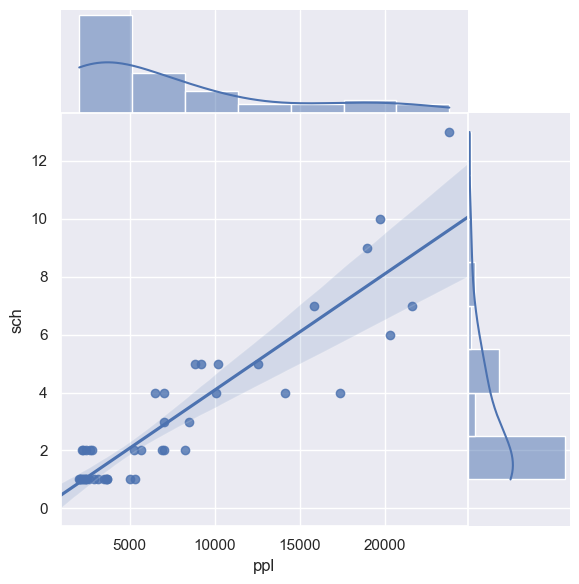

In [9]:
sns.jointplot(towns, x='ppl', y='sch', kind='reg', 
              ratio=4, space=0, truncate=False)

In [10]:
ppl_1000 = towns.ppl / 1000

In [11]:
slope, intercept = np.polyfit(ppl_1000, towns.sch, deg=1)
slope, intercept

(0.4013147751338797, 0.07201462051524599)

Наклон показывает, насколько изменится значение целевого признака при изменении
входного признака на $1$. Поскольку значения целевого признака выражены в целых 
числах, величину наклона можно трактовать следующим образом: рост населения 
в городе на $2.5$ тыс. человек приведет, в среднем, к строительству одной
начальной школы.

***
### <a id='toc1_1_1_'></a>[__Анализ степени адекватности уравнения регрессии__](#toc0_)

Функция регрессии, построенная на некотором наборе данных, должна быть
проверена на адекватность. Рассмотрим три способа проверки адекватности:

1. доля дисперсии целевого признака, учтенная в уравнении регрессии, коэффициент 
детерминации: чем его значение больше, тем точнее регрессионное уравнение 
описывает связь признаков;
2. доверительные интервалы для параметров регрессии — их диапазоны могут
дать представление об устойчивости регрессии;
3. непосредственное тестирование точности прогноза как на данных, использованных 
для построения регрессии, так и на тех, что не использовались для ее
построения.

***
#### <a id='toc1_1_1_1_'></a>[__Коэффициент детерминации__](#toc0_)

См. $R^2$ и $\rho$ в [__ml_linreg.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_linreg/ml_linreg.ipynb) и [__stats_tests.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/stats_tests.ipynb).

В теории линейных регрессионных уравнений Гальтона-Пирсона широко
применяется понятие __коэффициента корреляции__ ($\rho$), отражающего уровень «линейной 
связи» между двумя признаками. Его квадрат, называемый __коэффициентом
детерминации__ ($R^2$), может быть использован для быстрой оценки уровня адекватности
уравнения линейной регрессии: он характеризует долю дисперсии целевой переменной $y$, объясненную ее, целевой переменной, регрессией через предиктор $x$. Коэффициент корреляции находится в интервале между $-1$ и $1$, и если его величина близка к $1$ или $-1$, то это означает, что признаки связаны 
линейным уравнением с точностью до малых ошибок. Коэффициент корреляции 
признаков _ppl_ и _sch_ равен $0.909$. В физике или химии высокое значение
коэффициента корреляции — распространенное явление; в социальных науках —
нет, так что рассматриваемый пример — скорее исключение, чем правило.

In [12]:
pearsonr(towns.ppl, towns.sch)  # also: from statistics import correlation

PearsonRResult(statistic=0.9089636399544838, pvalue=6.0589349772489665e-18)

Многие другие признаки в данных о городах, такие как число почтовых отделений 
или докторов, также сильно связаны с признаком _ppl_, но, например, наличие
фермерского рынка (_frm_) уже с _ppl_ никак не связано. Низкое значение коэффициента
корреляции, $0.15$, говорит о том, что размер города не является здесь существенным: 
вероятность наличия фермерского рынка в маленьком городе такая же,
как и в большом.

[__seaborn.heatmap__](https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn-heatmap)

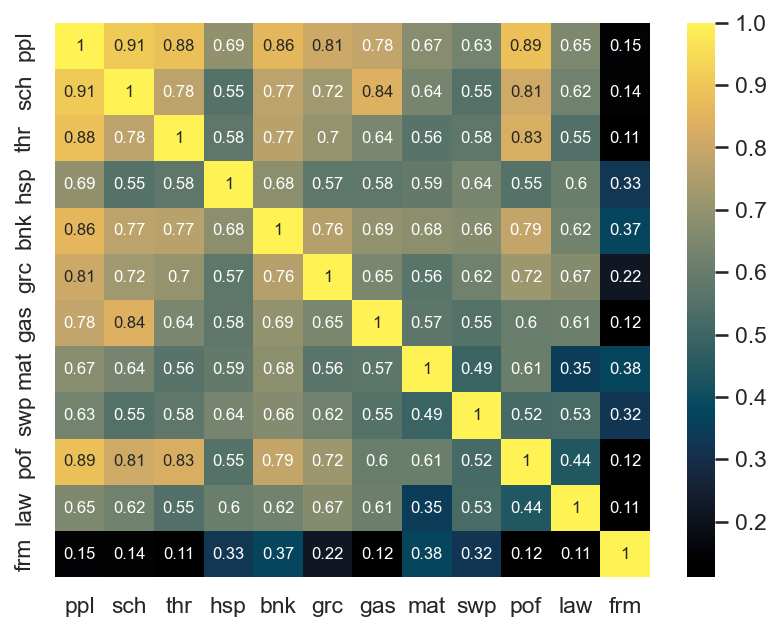

In [13]:
plt.figure(dpi=150)
sns.heatmap(towns.corr(), cmap=cmasher.eclipse,
            annot=True, annot_kws={'size': 8})
plt.show()

Совсем низкое или нулевое значение коэффициента корреляции не всегда
означает отсутствие взаимосвязи. Речь идет об отсутствии именно _линейной_
связи. Нулевой коэффициент корреляции может соответствовать другому, более
тонкому, типу функциональной зависимости.

$R^2 = 0.909^2 = 0.826$. Это показывает, что линейная связь _sch_ и _ppl_ снижает разброс значений _sch_ на $82.6\%$ — довольно высокое значение.

Если величина коэффициента детерминации мала, гипотезу о линейной зависимости 
признаков все же отвергнуть из-за этого одного факта нельзя. Это зависит 
от распределения остатков регрессии, т.е. от разности наблюдаемых значений
_sch_ и значений, вычисленных по _ppl_ с помощью уравнения регрессии. Это распределение 
должно быть Гауссовым или близким к таковому, так чтобы применение
принципа максимального правдоподобия приводило к соответствующим выводам.

<AxesSubplot: ylabel='Count'>

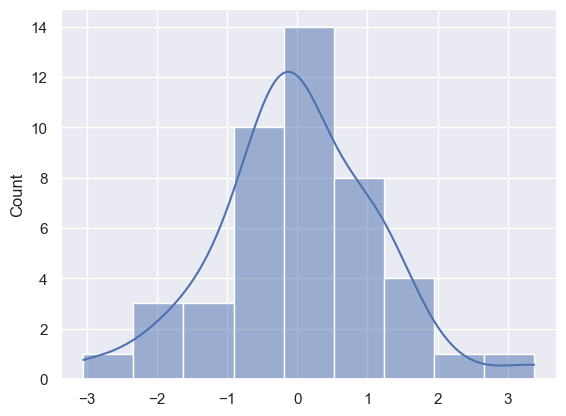

In [14]:
resid = towns.sch - (slope * ppl_1000 + intercept)
sns.histplot(x=resid, kde=True)

In [15]:
model = sm.OLS(towns.sch, sm.add_constant(ppl_1000))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sch   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     204.4
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           6.06e-18
Time:                        16:15:19   Log-Likelihood:                -69.239
No. Observations:                  45   AIC:                             142.5
Df Residuals:                      43   BIC:                             146.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0720      0.269      0.268      0.790      -0.470       0.614
ppl            0.4013      0.028     14.298      0.000       0.345       0.458
==============================================================================
Omnibus:                        3.175   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.604
Skew:                           0.069   Prob(JB):                        0.272
Kurtosis:                       4.170   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
res.resid.head(10)

town
Mullion            0.109303
South Brent        0.090441
St Just            0.088435
St Columb Minor    0.077599
Nanpean            1.033053
Gunnislake         1.030646
Mevagissey         0.016198
Ipplepen           0.014994
Alston            -0.019920
Lostwithiel        0.943962
dtype: float64

In [17]:
np.allclose(res.resid, resid)

True

In [18]:
res.params

const    0.072015
ppl      0.401315
dtype: float64

In [19]:
res.bse

const    0.268554
ppl      0.028068
dtype: float64

In [20]:
res.rsquared

0.8262148987593045

***
#### <a id='toc1_1_1_2_'></a>[__Тестирование адекватности с помощью бутстрэпа__](#toc0_)

Более простое тестирование корректности может быть проведено без обращения 
к какой-либо статистической теории вообще, а с использованием только лишь
вычислительных средств. Бутстрэп — это способ вычисления множества оценок
интересующих нас параметров с помощью случайных подвыборок (с возвращением) 
из множества наблюденных данных.

Насколько устойчивы найденные значения наклона и сдвига при возникновении изменений в выборке? Именно это проверяется с помощью процедуры бутстрэп.

In [21]:
def conf_interval_non_pivotal(bs_distr, conf_level):
    proportiontocut = (100 - conf_level * 100) / 200
    bs_distr_trimmed = trimboth(bs_distr, proportiontocut)
    return bs_distr_trimmed.min(), bs_distr_trimmed.max()

In [22]:
def conf_interval_pivotal(bs_distr, conf_level):
    return norm.interval(conf_level, np.mean(bs_distr), np.std(bs_distr, ddof=1))

In [23]:
cases = 'ci_non_pivotal', 'ci_pivotal'
funcs = conf_interval_non_pivotal, conf_interval_pivotal

In [24]:
def plot_slope_and_intercept_bs_distrs(
    predictor, target, *, n_resamples, conf_level=0.95
):
    # initialize report dict
    report = {'n_resamples': n_resamples, 'conf_level': conf_level}
    
    # get bootstrap distributions: col0 - slope, col1 - intercept
    coeffs = np.stack([np.polyfit(*resample(predictor, target), deg=1)
                       for _ in range(n_resamples)])
    
    # plot slope and intercept bootstrap distributions
    axs = plt.subplots(1, 2, figsize=(9,3), dpi=120)[1]
    axs_iter = axs.flat
    
    for coeff_distr, coeff_name in zip(coeffs.T, ['slope', 'intercept']):
        ax = next(axs_iter)
        sns.histplot(x=coeff_distr, bins=20, kde=True, ax=ax)
        ax.set_title(coeff_name)        
        report.setdefault(coeff_name, {})['mean'] = np.mean(coeff_distr)
        for case, func in zip(cases, funcs):
            report[coeff_name][case] = func(coeff_distr, conf_level)
    
    plt.tight_layout()
    plt.show()
    return report

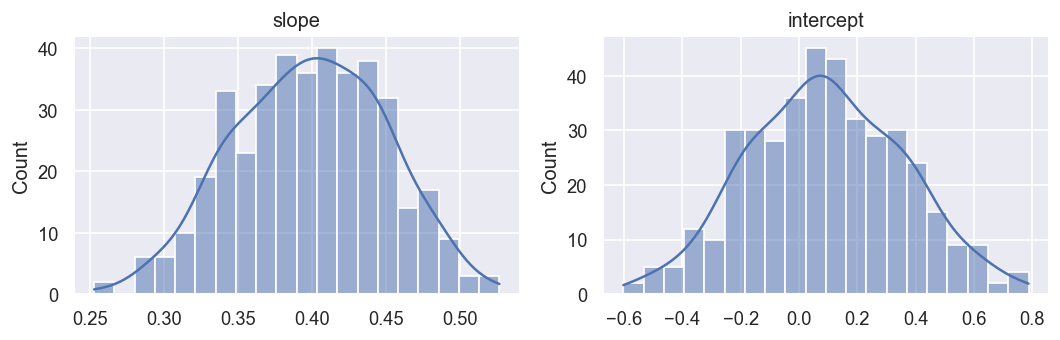

{
    "n_resamples": 400,
    "conf_level": 0.95,
    "slope": {
        "mean": 0.3985750569286185,
        "ci_non_pivotal": (0.29871064962012966, 0.4921866017376857),
        "ci_pivotal": (0.2989392120136118, 0.4982109018436252),
    },
    "intercept": {
        "mean": 0.09281634088991066,
        "ci_non_pivotal": (-0.419524530187559, 0.6078268070852115),
        "ci_pivotal": (-0.427224477779645, 0.6128571595594663),
    },
}



In [25]:
print_black(plot_slope_and_intercept_bs_distrs(
    ppl_1000, towns.sch, 
    n_resamples=400
))

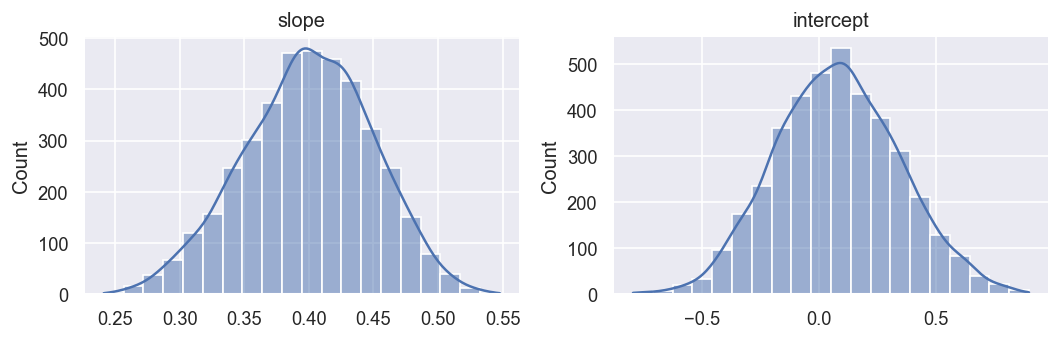

{
    "n_resamples": 4000,
    "conf_level": 0.95,
    "slope": {
        "mean": 0.39974327014398886,
        "ci_non_pivotal": (0.29836381709288495, 0.49147051081841686),
        "ci_pivotal": (0.3022076605803388, 0.4972788797076389),
    },
    "intercept": {
        "mean": 0.07846060910842965,
        "ci_non_pivotal": (-0.41680458775604623, 0.6086990322574707),
        "ci_pivotal": (-0.4386384320587534, 0.5955596502756128),
    },
}



In [26]:
print_black(plot_slope_and_intercept_bs_distrs(
    ppl_1000, towns.sch, 
    n_resamples=4000
))

In [27]:
res.conf_int(alpha=0.05)  # conf_level = 1 - 0.05 = 0.95

,0,1
const,-0.469576,0.613605
ppl,0.344710,0.457919


Как получены эти доверительные интервалы для коэффициентов регрессии:

[__scipy.stats.t__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.t.html#scipy-stats-t) | [__ml_linreg.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_linreg/ml_linreg.ipynb)

In [28]:
df = pd.DataFrame({'loc': res.params, 'scale': res.bse})
df['high'], df['low'] = t.interval(0.95, loc=df['loc'], scale=df['scale'], 
                                   df=towns.shape[0] - 2)
df

,loc,scale,high,low
const,0.072015,0.268554,-0.469576,0.613605
ppl,0.401315,0.028068,0.344710,0.457919


Оценка дисперсии разностей между наблюдаемыми значениями _sch_ и вычисленными по уравнению регрессии:

In [29]:
res.mse_resid

1.3295682887686078

In [30]:
res.mse_resid == res.scale == resid.var(ddof=2)

True

***
#### <a id='toc1_1_1_3_'></a>[__Минимизация средней относительной ошибки прогноза по уравнению регрессии__](#toc0_)

Средняя относительная ошибка в уравнении регрессии, обученной на MSE, составляет $30.7\%$:

In [31]:
mean_absolute_percentage_error(towns.sch, res.fittedvalues)

0.3067886887258197

Можно ли ее сделать меньше?
$$L_{\tiny \text{MAPE}}(y, a) = \biggl|\frac{y - a}{y}\biggr| = \biggl|\frac{y - w_0 - w_1 x}{y}\biggr|$$

Найдем пару $(w_0,w_1)$, минимизирующую MAPE на векторах _ppl_ и _sch_: 

In [32]:
L = lambda w: np.mean(np.abs((towns.sch - w[0] - w[1]*ppl_1000) / towns.sch))

[__scipy.optimize.minimize__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.minimize.html#scipy-optimize-minimize)

In [33]:
result = minimize(L, x0=(intercept, 0), method='Nelder-Mead')
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.26379640352134603
             x: [ 3.415e-01  2.788e-01]
           nit: 91
          nfev: 174
 final_simplex: (array([[ 3.415e-01,  2.788e-01],
                       [ 3.414e-01,  2.788e-01],
                       [ 3.415e-01,  2.788e-01]]), array([ 2.638e-01,  2.638e-01,  2.638e-01]))

In [34]:
result.x  # intercept, slope

array([0.34153358, 0.27877327])

Средняя относительная ошибка снизилась с $30.7\%$ до $26.4\%$:

In [35]:
result.fun

0.26379640352134603

***
### <a id='toc1_1_2_'></a>[__Влияние выбросов на коэффициент корреляции__](#toc0_)

Наличие выбросов — сильно выделяющихся наблюдений — может сильно
исказить картину корреляции между признаками, обычно в сторону увеличения
корреляции.

In [36]:
rng = np.random.default_rng()
x_ = 10 * rng.random(size=500) - 4
y_ = rng.normal(loc=4, scale=5, size=500)

In [37]:
def plot_features_with_outliers(*, outliers=[]):
    features = [np.r_[f, outliers] for f in (x_, y_)]
    params = dict(zip('xy', features))
    sns.jointplot(space=0, **params)
    return pearsonr(*features)[0]

0.011110520975417886

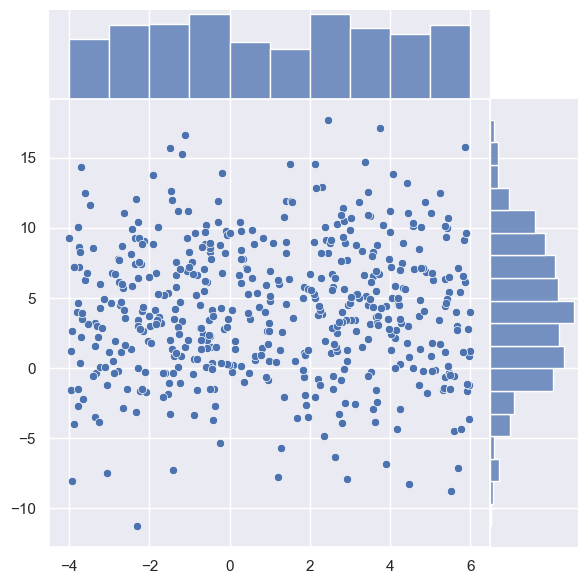

In [38]:
plot_features_with_outliers()

0.7284145275543821

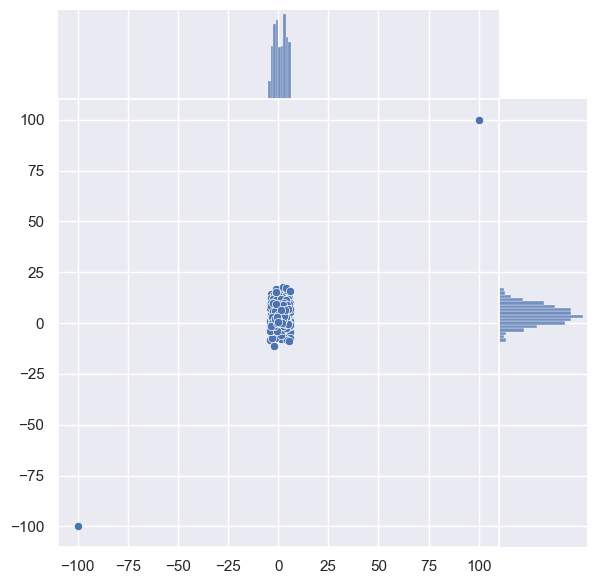

In [39]:
plot_features_with_outliers(outliers=[-100, 100])

Добавление двух выбросов полностью поменяло масштаб. В новом масштабе исходные $500$ объектов — не более чем случайное нагромождение реализаций как бы единой «средней»
точки, а «реальная» картина связи между $x\_$ и $y\_$ определяется взаиморасположением 
трех «главных» сил — два выброса и клякса посередине.

***
### <a id='toc1_1_3_'></a>[__Экспоненциальная регрессия: оптимизация против линеаризации__](#toc0_)

Нелинейные зависимости также могут быть аппроксимированы, причем
с помощью того же критерия минимизации среднего квадрата ошибки. Рассмотрим 
довольно распространенный случай экспоненциальной регрессии. В этом
случае речь идет о возможности описания связи целевого признака $y$ и входного
признака $x$ в виде 

$$y = ae^{bx},$$

где $a$ и $b$ — неизвестные константы, $e$ — основание натурального 
логарифма. При заданных $a$ и $b$ средний квадрат невязки вычисляется
как

$$E = \frac{1}{n} \sum_{i=1}^n (y_i - ae^{bx_i})^2.$$

Не существует метода, который бы непосредственно давал глобально оптимальное 
решение задачи минимизации $E$, поскольку функция
$E$ довольно сложна. Вот почему частенько коэффициенты уравнения экспоненциальной 
регрессии отыскиваются с помощью предварительной линеаризации:

$$y = ae^{bx} \\
\ln y = bx + \ln a$$

Найденные значения $a$ и $b$ не обязательно минимизируют $E$, но, предположительно, близки к оптимуму. Иногда это может быть совсем не так.

Признак $y$ моделирует рост инвестиций, зашумленный Гауссовой ошибкой:

In [40]:
x = np.arange(0.1, 2.1, 0.1)
f = lambda x, a, b: a * np.exp(b*x)
rng = np.random.default_rng(11)
y = f(x, 2, 1.04) + 0.6 * rng.normal(size=x.size)

Нахождение коэффициентов линеаризацией:

In [41]:
b_lin, ln_a = np.polyfit(x, np.log(y), deg=1)
a_lin = np.exp(ln_a)
a_lin, b_lin

(2.1316838264539375, 1.0005973960455037)

Нахождение коэффициентов оптимизацией:

In [42]:
L = lambda w: np.mean((y - w[0] * np.exp(w[1] * x))**2)

[__scipy.optimize.minimize__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.minimize.html#scipy-optimize-minimize)

In [43]:
minimize(L, x0=(a_lin, b_lin))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.21844325846817547
        x: [ 2.060e+00  1.029e+00]
      nit: 7
      jac: [ 6.892e-08  2.347e-07]
 hess_inv: [[ 5.038e-01 -1.440e-01]
            [-1.440e-01  4.386e-02]]
     nfev: 30
     njev: 10

[__scipy.optimize.differential_evolution__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.differential_evolution.html#scipy-optimize-differential-evolution)

In [44]:
evol_res = differential_evolution(L, [(1, 2), (1, 2)])
evol_res

 message: Optimization terminated successfully.
 success: True
     fun: 0.22205683436580656
       x: [ 2.000e+00  1.047e+00]
     nit: 14
    nfev: 474
     jac: [-1.217e-01  6.870e-06]

[__scipy.optimize.curve_fit__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.curve_fit.html#scipy-optimize-curve-fit)

In [45]:
curve_fit(f, x, y)[0]

array([2.05986904, 1.02933438])

In [46]:
a_opt, b_opt = evol_res.x

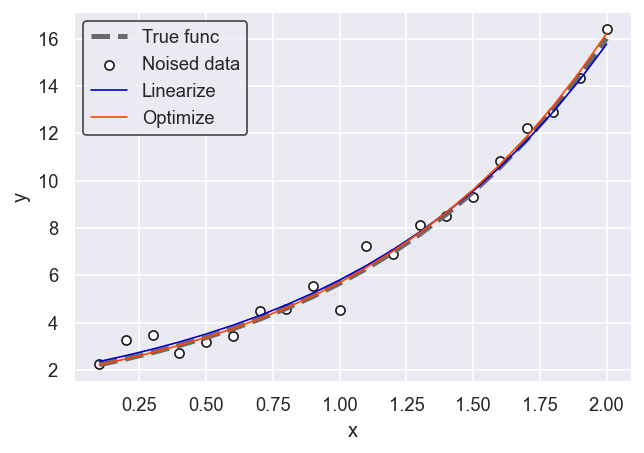

In [47]:
plt.figure(figsize=(6,4), dpi=120)
plt.plot(x, f(x, 2, 1.04), ls='--', lw=3, c='dimgray', label='True func')
plt.scatter(x, y, s=30, c='w', ec='k', label='Noised data')
plt.plot(x, a_lin * np.exp(b_lin * x), lw=1, c='mediumblue', label='Linearize')
plt.plot(x, a_opt * np.exp(b_opt * x), lw=1, c='orangered', label='Optimize')
plt.xlabel('x')
plt.ylabel('y')
plt.legend().get_frame().set_edgecolor('k')
plt.show()

***
### <a id='toc1_1_4_'></a>[__Степенная регрессия: оптимизация против линеаризации__](#toc0_)

Задача степенной регрессии может быть сформулирована как
задача минимизации суммы квадратов или абсолютных значений ошибки по всем
парам коэффициентов $a$ и $b$. Заметим, что не существует метода, который сразу
непосредственно приведет к глобально оптимальному решению задачи, поскольку
минимизация суммы экспонент — сложная проблема. На практике уравнение степенной 
регрессии часто перезаписывают в виде уравнения линейной регрессии
путем применения операции логарифмирования:

$$y = ax^b \\
\ln y = b \ln x + \ln a$$

Этот способ часто дает высокое значение коэффициенту детерминации, поскольку логарифмирование сильно сглаживает данные. Однако надо иметь в виду то, что найденные коэффициенты оптимальны для уравнения линейной регрессии, не обязательно означает, что при обратном переходе к степенной записи они также будут оптимальными. Рассмотрим 
иллюстрацию этого утверждения.

Признак $y$ моделирует тренд $7\%$-ого роста, сильно зашумленного Гауссовой
ошибкой:

In [48]:
x = np.linspace(1e-6, 10, 50)  # x != 0 для log(x) != -inf
f = lambda x, a, b: a * x**b
y = f(x, 2, 1.07)

rng = np.random.default_rng(77)

for i in range(50):
    while True:
        noise = rng.normal(loc=0, scale=2)
        if (y_noisy := y[i] + noise) > 1:  # y > 1 для log(y) > 0
            y[i] = y_noisy
            break

Нахождение коэффициентов линеаризацией:

In [49]:
b_lin, ln_a = np.polyfit(np.log(x), np.log(y), deg=1)
a_lin = np.exp(ln_a)
a_lin, b_lin

(7.734010825688898, 0.14416783775258174)

Нахождение коэффициентов оптимизацией:

In [50]:
L = lambda w: np.mean((y - w[0] * x**w[1])**2)

[__scipy.optimize.minimize__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.minimize.html#scipy-optimize-minimize)

In [51]:
minimize(L, x0=(a_lin, b_lin))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.5143908652700344
        x: [ 1.997e+00  1.068e+00]
      nit: 14
      jac: [ 3.278e-07  5.960e-07]
 hess_inv: [[ 4.803e-01 -1.178e-01]
            [-1.178e-01  2.958e-02]]
     nfev: 60
     njev: 20

[__scipy.optimize.differential_evolution__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.differential_evolution.html#scipy-optimize-differential-evolution)

In [52]:
differential_evolution(L, [(1, 10), (1, 2)])

 message: Optimization terminated successfully.
 success: True
     fun: 3.5143908652701636
       x: [ 1.997e+00  1.068e+00]
     nit: 13
    nfev: 468
     jac: [ 1.412e-05  5.818e-05]

[__scipy.optimize.curve_fit__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.curve_fit.html#scipy-optimize-curve-fit)

In [53]:
a_opt, b_opt = curve_fit(f, x, y)[0]
a_opt, b_opt

(1.9966689963101574, 1.0675062164594369)

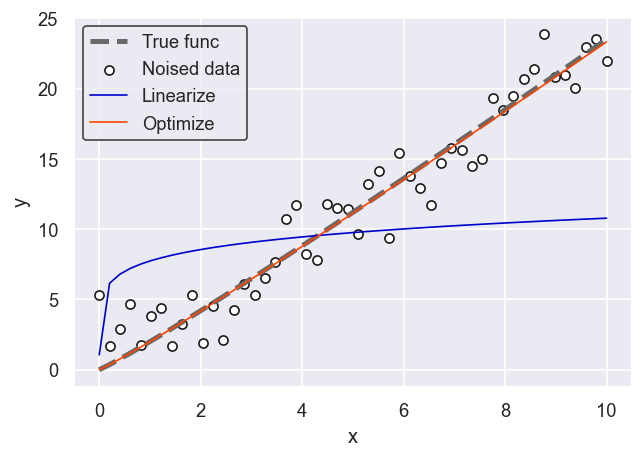

In [54]:
plt.figure(figsize=(6,4), dpi=120)
plt.plot(x, f(x, 2, 1.07), ls='--', lw=3, c='dimgray', label='True func')
plt.scatter(x, y, s=30, c='w', ec='k', label='Noised data')
plt.plot(x, a_lin * x**b_lin, lw=1, c='mediumblue', label='Linearize')
plt.plot(x, a_opt * x**b_opt, lw=1, c='orangered', label='Optimize')
plt.xlabel('x')
plt.ylabel('y')
plt.legend().get_frame().set_edgecolor('k')
plt.show()

Пример показывает, что процедура линеаризации может приводить к совершенно 
неправильным оценкам. Поэтому лучше ею не пользоваться.

***
## <a id='toc1_2_'></a>[__Случай смешанных шкал: номинальный и количественный признаки__](#toc0_)

***
### <a id='toc1_2_1_'></a>[__Целевой количественный признак. Бокс-плот, табличная регрессия, корреляционное отношение__](#toc0_)

In [55]:
cyber_attacks = pd.read_csv('cyber_attacks.csv')
cyber_attacks.head()

,Pr,BySD,SH,SS,SE,RE,A
0,TCP,62344,16,16,0.00,0.94,ap
1,TCP,60884,17,17,0.06,0.88,ap
2,TCP,59424,18,18,0.06,0.89,ap
3,TCP,59424,19,19,0.05,0.89,ap
4,TCP,59424,20,20,0.05,0.90,ap


In [56]:
cyber_attacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pr      100 non-null    object 
 1   BySD    100 non-null    int64  
 2   SH      100 non-null    int64  
 3   SS      100 non-null    int64  
 4   SE      100 non-null    float64
 5   RE      100 non-null    float64
 6   A       100 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 5.6+ KB


* Pr — тип протокола, в данном случае один из трех: _TCP, ICMP, UDP_ (номинальный признак).
* BySD — число байтов в пакете.
* SH — количество соединений источника за последние две секунды.
* SS — число соединений с тем же сервером за последние две секунды.
* SE — процент ошибочных соединений.
* RE — процент соединений с отказом обслуживания.
* A — тип атаки (_ap_ — apache2, _sa_ — SAINT, _sm_ — smurf, _no_ — отсутствие атаки).

Информация о связи количественного и качественного признаков может быть
представлена в виде так называемой __табличной регрессии__. Табличная регрессия
$y$ по $x$ — это трехстолбцовая таблица, строки которой соответствуют категориям $x$.
В каждой строке размещается следующая информация о категории:
* численность категории;
* среднее значение $y$ внутри категории;
* стандартное отклонение $y$ внутри категории.

Последняя, «маргинальная», строка содержит такую же информацию для всего
множества объектов.

[__pandas.pivot_table__](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html#pandas-pivot-table)

In [57]:
def regression_table(df, *, qual_feature, quant_feature):
    return pd.pivot_table(df, index=qual_feature, values=quant_feature, 
                          aggfunc=['count', 'mean', 'std'], margins=True)

Табличная регрессия количества соединений _SH_ (количественный целевой признак) по типу
протокола _Pr_ (категоризованный входной признак) для данных о компьютерных атаках:

In [58]:
regression_table(cyber_attacks, qual_feature='Pr', quant_feature='SH')

,count,mean,std
,SH,SH,SH
Pr,,,
ICMP,10,508.400000,5.125102
TCP,64,98.984375,177.704721
UDP,26,2.153846,1.376730
All,100,114.750000,198.094324


__Бокс-плот__ количества соединений _SH_ (количественный целевой 
признак) по типу протокола (категоризованный входной признак) для данных
о компьютерных атаках:

[__seaborn.boxplot__](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn-boxplot)

<AxesSubplot: xlabel='Pr', ylabel='SH'>

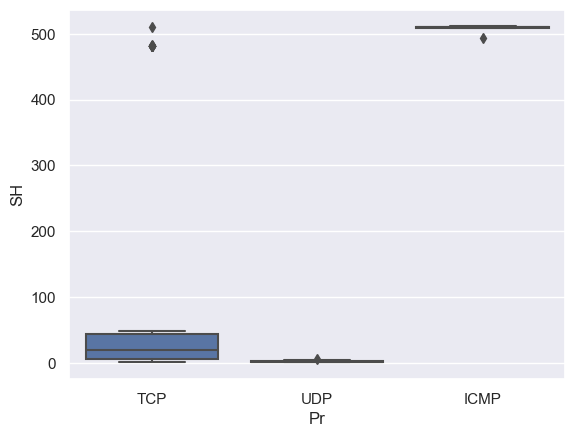

In [59]:
sns.boxplot(cyber_attacks, x='Pr', y='SH')

[__scipy.stats.iqr__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.iqr.html#scipy-stats-iqr)

Quick reminder:
* Коробка: центральные $50\%$, или $Q_3 - Q_1 = IQR$. Внутри - медиана.
* Усы (_whiskers_) показывают диапазон значений, из которого исключены выбросы (_outliers_).
* outliers $\in (-\infty,\; Q_1 - 1.5\,IQR) \cup (Q_3 + 1.5\,IQR,\; +\infty)$.

<AxesSubplot: xlabel='A', ylabel='SH'>

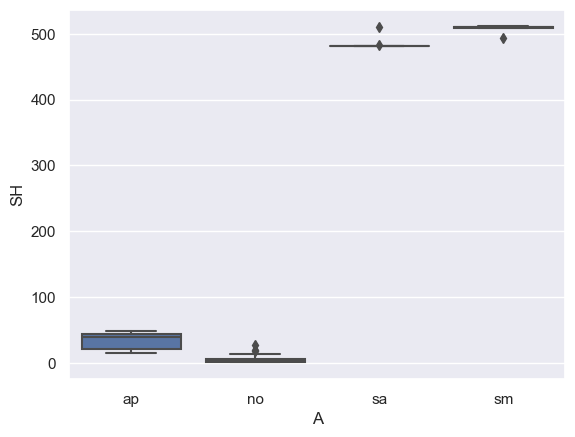

In [60]:
sns.boxplot(cyber_attacks, x='A', y='SH')

Интуитивно чувствуется, что связь типа атаки _A_ с _SH_ выше, чем связь типа протокола _Pr_, - боксы выглядят тоньше. Это указывает на то, что прогнозировать 
значения признака _SH_, зная тип атаки, можно точнее, чем зная тип протокола.

In [61]:
regression_table(cyber_attacks, qual_feature='A', quant_feature='SH')

,count,mean,std
,SH,SH,SH
A,,,
ap,23,33.608696,12.127126
no,56,5.125000,5.589153
sa,11,484.636364,8.417514
sm,10,508.400000,5.125102
All,100,114.750000,198.094324


Табличная регрессия количества соединений _SH_ (количественный целевой признак) по типу
атаки _A_ (категоризованный входной признак), в общем, подтверждает мнение о том, что тип атаки больше связан с SH, чем тип протокола, так как стандартные отклонения в группах одинаковых атак в среднем меньше, чем в группах одинаковых протоколов.

Но как установить это с непреложной точностью? К сожалению, в анализе данных
точность и полнота могут противоречить друг другу. Табличная регрессия отражает так
называемую кусочно-постоянную модель связи категоризованного и количественного
признака. Применение метода наименьших квадратов к оценке этой модели приводит к __коэффициенту корреляционного отношения, показывающему, 
какую долю дисперсии количественного признака позволяют учитывать категории
номинального признака__. Этот-то коэффициент и принимается часто за характеристику
силы связи номинального и количественного признака. __Коэффициент корреляционного
отношения оценивает, насколько дисперсия внутри групп меньше, чем дисперсия значений 
признака до его разбиения на категории__; это аналог коэффициента детерминации для
обычной регрессии.

Если количественный признак $y$ задан без какой-либо дополнительной информации, то среднее значение этого признака, $\overline{y} = \frac{1}{N} \sum_{i=1}^N y_i$, представляет собой разумную суммаризацию имеющихся данных. Однако если становятся известными категории номинального признака $x$, то можно получить более детальную информацию: средние значения $y$ в категориях. Обозначим через $S_k$ множество объектов в категории $k$ признака $x$. Среднее значение внутри этой категории равно

$$\overline{y}_k = \frac{1}{|S_k|} \sum_{i \in S_k} y_i.$$

Эти средние можно считать решением уравнения табличной регрессии
по методу наименьших квадратов. Подход восстановления данных применительно 
к этой ситуации можно сформулировать следующим образом. Найдем
внутригрупповые центральные значения $c_k$ так, чтобы минимизировать суммарную 
квадратичную ошибку

$$L = \sum_{i=1}^N \varepsilon_i^2,$$

где $\varepsilon_i$ — невязка уравнения

$$y_i = c_k + \varepsilon_i, \quad i \in S_k,$$

«декодирующего» каждое наблюденное значение $y$ характеристическим числом
$c_k$, представляющим категорию $k \in \{1,2,\ldots,K\}$. (Это отсылка к восстановлению данных по центру Минковского из второй главы).

Это уравнение лежит в основе табличной регрессии, называемой также
__кусочно-постоянной регрессией__. Нетрудно показать, что оптимальная по критерию 
наименьших квадратов величина $c_k$ равна среднему значению внутри категории $\overline{y}_k$. Отсюда следует, что минимальное значение критерия $L$ равно

$$L_m = \sum_{k=1}^K \sum_{i \in S_k}\left(y_i - \overline{y}_k\right)^2 = \sum_{k=1}^K |S_k| \cdot \overbrace{\frac{1}{|S_k|} \sum_{i \in S_k}\left(y_i - \overline{y}_k\right)^2}^{\sigma^2_k} =$$

$$= N \cdot \sum_{k=1}^K \frac{|S_k|}{N} \sigma^2_k = N \cdot \sum_{k=1}^K p_k \sigma^2_k = N \sigma^2_w,$$

где $\sigma^2_w$ - внутригрупповая (_within-group_) дисперсия (средневзвешенное
среднее дисперсий $y$ во всех группах), $p_k = |S_k|/N$ - доля категории $k$, $\sigma^2_k$ - дисперсия $y_k$ в $S_k$.

Для дальнейшего анализа рассмотрим тождество

$$(y_i - \overline{y}_k)^2 = y_i^2 - 2 y_i \overline{y}_k + \overline{y}^2_k.$$

и просуммируем его по всем $i \in S_k$:

$$\sum_{i \in S_k} (y_i - \overline{y}_k)^2 = \sum_{i \in S_k} y_i^2 - 2 \cdot |S_k| \overline{y}_k \cdot \overline{y}_k + |S_k| \overline{y}^2_k = \sum_{i \in S_k} y_i^2 - |S_k| \overline{y}^2_k.$$

Просуммируем по $k$ с переносом из правой части в левую:
$$\sum_{i=1}^N y_i^2 = \sum_{k=1}^K |S_k| \overline{y}^2_k + \sum_{k=1}^K \sum_{i \in S_k} (y_i - \overline{y}_k)^2.$$

Справа стоит сумма квадратов невязок модели $L_m$. Это позволяет интерпретировать уравнение как декомпозицию квадратичного разброса переменной $y$: эта величина (слева) разделяется на два слагаемых (справа), называемых __объясненной и необъясненной частями квадратичного разброса__.

Объясненная часть суммирует вклады $|S_k|\overline{y}^2_k$ отдельных категорий $k$. Величина вклада пропорциональна и частоте категории, и квадрату среднего. Еще одна интерпретация декомпозиции квадратичного разброса может быть сделана, если признак $y$ центрирован, так что его среднее значение равно нулю. В этом случае, разделив уравнение на $N$, получим

$$\sigma^2 = \sum_{k=1}^K p_k \overline{y}^2_k + \sum_{k=1}^K p_k \sigma^2_k,$$

где $\sigma^2$ - дисперсия $y$, правая сумма - $L_m / N = \sigma^2_w$, а левая сумма — это взвешенная сумма квадратов расстояний между общим средним $\overline{y} = 0$ и средними внутригрупповыми значениями $\overline{y}_k$.

В статистике последнее уравнение известно как разложение дисперсии
на внутригрупповую и межгрупповую составляющие. Оно лежит в основе широко
используемого метода сравнения средних внутригрупповых значений, называемого 
_дисперсионный анализ_, по-английски __ANOVA__ (ANalysis Of VAriance).

Корреляционное отношение характеризует среднее уменьшение дисперсии
признака и при прогнозировании его величины с помощью уравнения $y_i = c_k + \varepsilon_i, \; i \in S_k$, или, иными словами, относительную долю объясненной части дисперсии. 

Корреляционное отношение обычно обозначается $\eta^2$ и определяется формулой:

$$\Large \eta^2 = 1 - \frac{\sigma^2_w}{\sigma^2}.$$

Из определения следуют следующие __свойства корреляционного отношения__:

* $\eta^2$ принимает значения в интервале от 0 до 1;
* $\eta^2 = 1$, если и только если все внутригрупповые дисперсии равны нулю, $\sigma^2_k = 0$, т.е. когда $y$ постоянно внутри каждой группы $S_k$;
* $\eta^2 = 0$, если и только если все $\sigma^2_k$ порядка $\sigma^2$.

In [62]:
def cor_relation(df, *, qual_feature, quant_feature):
    f = lambda group: group.size * group.var()
    within = df.groupby(qual_feature)[quant_feature].agg(f).sum() / df.shape[0]
    return 1 - within.item() / df[quant_feature].var()

In [63]:
cor_relation(cyber_attacks, qual_feature='Pr', quant_feature='SH')

0.4848889432443071

In [64]:
cor_relation(cyber_attacks, qual_feature='A', quant_feature='SH')

0.9984266662565311

Величина коэффициента корреляционного отношения в последнем случае составляет почти единицу — внутригрупповые дисперсии _SH_ в группах по типу _атаки_ (в учебнике _протокола_ - вероятно, опечатка) значительно ниже, чем общая дисперсия.
Напротив, для протокола _TCP_ внутригрупповая дисперсия сравнима по величине с общей
дисперсией, что и предопределяет значительно меньшую связь между _SH_ с типом протокола.

***
### <a id='toc1_2_2_'></a>[__Номинальный целевой признак__](#toc0_)

***
#### <a id='toc1_2_2_1_'></a>[__Классификатор по правилу $k$ ближних соседей__](#toc0_)

In [65]:
iris, iris_y = load_iris(return_X_y=True, as_frame=True)
iris.head()  # sepal - чашелистик, petal - лепесток

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [66]:
iris.shape

(150, 4)

In [67]:
def abbreviate(col_name):
    return ''.join(word[0] for word in col_name.split()[:2]).upper()

In [68]:
iris.rename(columns=abbreviate, inplace=True)
iris.head()

,SL,SW,PL,PW
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


$w_i = w_i(x_i,z) = \frac{1}{d^2(x_i,z)}$ - см. _Взвешенный kNN_ в [__ml_knn_nbayes.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_knn_nbayes/ml_knn_nbayes.ipynb)

In [69]:
def d2(dist_array):
    return (dist_array + 1e-3)**(-2)

In [70]:
k = 3, 9, 15  # число соседей
params = list(product(k, ['uniform', d2]))  # список - для переиспользования

Обучение на всех четырех признаках половины объектов датасета:

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.values, iris_y.values, test_size=0.5, random_state=42
)

keys = 'n_neighbors', 'weights', 'score'

for n_neighbors, weights in params:
    clf = KNeighborsClassifier(
        n_neighbors, weights=weights
    )
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
        
    if callable(weights):
        weights = weights.__name__
        
    values = n_neighbors, weights, score
    print(dict(zip(keys, values)))

{'n_neighbors': 3, 'weights': 'uniform', 'score': 0.9733333333333334}
{'n_neighbors': 3, 'weights': 'd2', 'score': 0.9866666666666667}
{'n_neighbors': 9, 'weights': 'uniform', 'score': 0.96}
{'n_neighbors': 9, 'weights': 'd2', 'score': 0.9733333333333334}
{'n_neighbors': 15, 'weights': 'uniform', 'score': 0.9733333333333334}
{'n_neighbors': 15, 'weights': 'd2', 'score': 0.9733333333333334}


Обучение только на признаках _sepal length_ и _sepal width_:

In [72]:
X, y = iris[['SL', 'SW']].values, iris_y.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

In [73]:
suptitle = ('Классификация ирисов по sepal length и sepal width '
            'в зависимости от числа соседей и функции весов')

# круги вокруг объектов обучающей выборки; строка 'None' для прозрачности 
xtrain_aes = dict(s=100, color='None', edgecolor='k') 

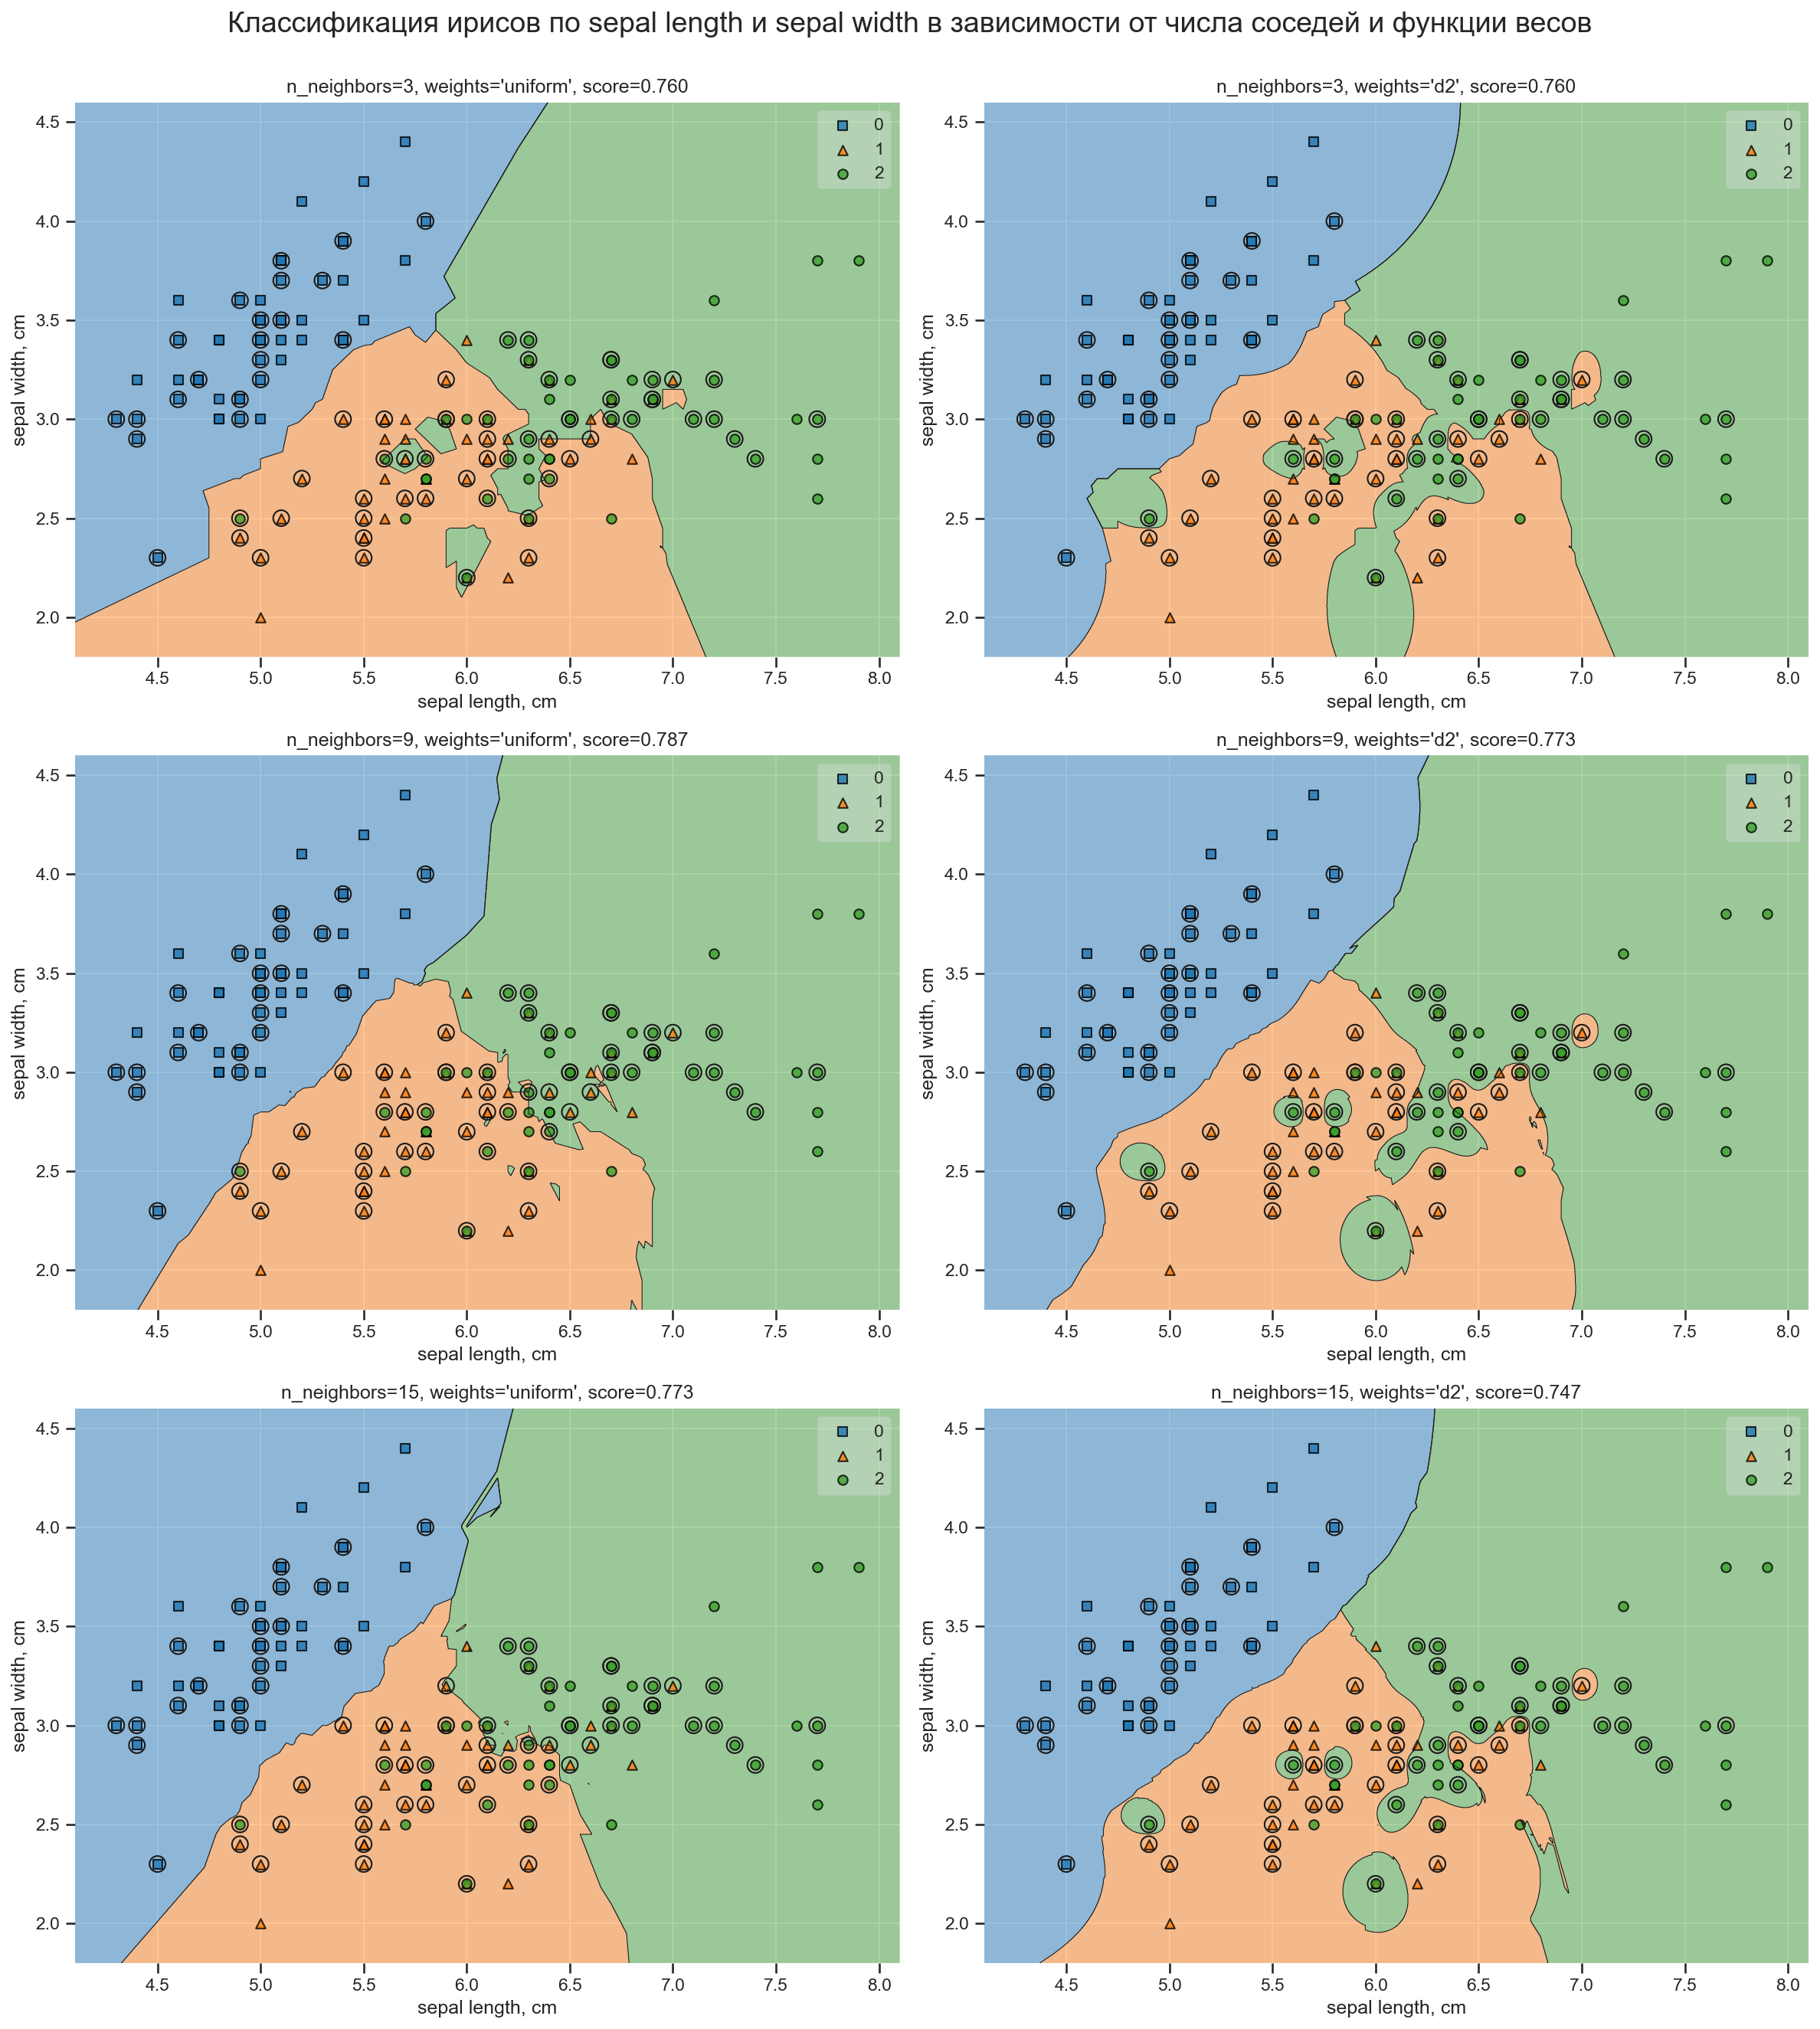

In [74]:
axs = plt.subplots(3, 2, figsize=(16, 18), dpi=150)[1]
axs_iter = axs.flat

for n_neighbors, weights in params:
    clf = KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    if callable(weights):
        weights = weights.__name__
    
    ax = next(axs_iter)
    plot_decision_regions(X, y, clf, ax=ax, zoom_factor=5)
    ax.scatter(*X_train.T, **xtrain_aes)
    ax.set_xlabel('sepal length, cm')
    ax.set_ylabel('sepal width, cm')
    ax.set_title(f'{n_neighbors=}, {weights=}, {score=:.3f}')
    
plt.suptitle(suptitle, fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

***
#### <a id='toc1_2_2_2_'></a>[__Классификатор с интервальными предикатами__](#toc0_)

Классификатор может быть построен с использованием интервалов количественного признака $x$. Для
того чтобы спрогнозировать категорию $k$ целевого признака, этот классификатор
ссылается на интервальный предикат (индикатор события) $x \in [a_k, b_k]$, значение которого «истина»
тогда и только тогда, когда величина $x$ лежит между $a_k$ и $b_k$. Рассмотрим для примера атаку _sa_ в данных о компьютерных атаках: имеется $11$ случаев атак такого типа и все, кроме одного, имеют значения признака _SH_, равные $482$ или $483$. Таким образом, правило
интервального предиката _SH_ $\in [482, 483] \Rightarrow$ _sa_ даст $10$ корректных ответов из $11$, или $9\%$ ошибок.

Как узнать, какая из категорий наилучшим образом покрывается правилом
интервального предиката? Одно из предложений заключается в использовании
вкладов категорий в разброс $x$:

$$\text{contribution}_k = p_k \left(\overline{x} - \overline{x}_k\right)^2,$$

где $p_k = |S_k| / N$ — доля объектов в категории $k$, $\overline{x}$ — среднее количественного
признака на всех объектах, $\overline{x}_k$ — среднее в категории $k$. Исходят из того, что чем дальше отдалено среднее в категории от общего среднего, тем больше шанс, что и все объекты 
категории отдалены, так что ее нетрудно описать интервальным признаком. Конечно, в некоторых случаях многие объекты категории могут находиться далеко от среднего по категории, что приведет к ошибкам «интервального» прогноза.

In [75]:
def contribution_table(df, *, qual_feature, quant_feature):
    mean = df[quant_feature].mean()
    
    def proportion(group):
        return group.size / df.shape[0]
    
    def contribution(group):
        return proportion(group) * (mean - group.mean())**2
    
    return pd.pivot_table(df, index=qual_feature, values=quant_feature, 
                          aggfunc=[proportion, 'mean', contribution], 
                          margins=True)

In [76]:
contribution_table(cyber_attacks, qual_feature='A', quant_feature='SH')

,proportion,mean,contribution
,SH,SH,SH
A,,,
ap,0.23,33.608696,1514.299592
no,0.56,5.125000,6729.878750
sa,0.11,484.636364,15049.751420
sm,0.10,508.400000,15496.032250
All,1.00,114.750000,0.000000


Примеры построения интервальных предикатов:

Ложноотрицательное заключение, или "ложное против", или ошибка $2$-ого рода: эффект (событие атака _sa_) на объекте индекса $89$ есть, но классификатор его "прозевал":

In [77]:
true_cond = cyber_attacks.A == 'sa'
pred_cond = cyber_attacks.SH.isin([482, 483])

cyber_attacks[true_cond].index, cyber_attacks[pred_cond].index

(Int64Index([79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], dtype='int64'),
 Int64Index([79, 80, 81, 82, 83, 84, 85, 86, 87, 88], dtype='int64'))

Ложноположительное заключение, или "ложное за", или ошибка $1$-ого рода: эффекта (события атака _sm_) на индексе $89$ нет, но классификатор его идентифицировал:

In [78]:
true_cond = cyber_attacks.A == 'sm'
pred_cond = cyber_attacks.SH.between(490, 512)  # inclusive, default

cyber_attacks[true_cond].index, cyber_attacks[pred_cond].index

(Int64Index([90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype='int64'),
 Int64Index([89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype='int64'))

***
## <a id='toc1_3_'></a>[__Случай двух номинальных признаков. Таблица сопряженности__](#toc0_)

Для анализа связи между двумя номинальными признаками составляют так
называемые __таблицы сопряженности__ (или __перекрестную классификацию__). Строки таблицы сопряженности соответствуют 
категориям одного признака, а столбцы — категориям другого признака.
Элемент на пересечении строки и столбца — количество объектов, обладающих
соответствующими категориями и того и другого признаков.

In [79]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (2, 3), (4, 9), (10, towns.bnk.max())], closed='both'
)
# для относительных частот normalize=True
pd.crosstab(towns.frm, pd.cut(towns.bnk, bins=bins), margins=True)

bnk,"[0, 1]","[2, 3]","[4, 9]","[10, 19]",All
frm,,,,,
0,12,13,7,4,36
1,1,1,5,2,9
All,13,14,12,6,45


Таблица сопряженности может быть использована для исследования связи
между отдельными категориями. Наибольшая связь — концептуальная (логическая). Концептуальная связь усматривается тогда, когда в строке $k$ все немаргинальные величины, кроме одной, скажем в столбце $l$, равны $0$, что означает, что если объект имеет категорию $k$ первого признака, он заведомо будет иметь категорию $l$ второго признака. Это означает логическую импликацию, или
концептуальную связь $k \Rightarrow l$.

Таблица сопряженности для признаков тип протокола _Pr_ и тип
атаки _A_ в абсолютных численностях:

In [80]:
# для относительных частот normalize=True
pd.crosstab(cyber_attacks.Pr, cyber_attacks.A, margins=True)

A,ap,no,sa,sm,All
Pr,,,,,
ICMP,0,0,0,10,10
TCP,23,30,11,0,64
UDP,0,26,0,0,26
All,23,56,11,10,100


_UDP_ $\Rightarrow$ _no_; _ICMP_ $\iff$ _sm_

Сформируем из признака _ppl_ в данных о малых городах Англии
категоризованный признак «Величина поселения» с категориями «Малая» (до $2400$ жителей), «Средняя» (больше $2400$, но меньше $8500$ жителей) и «Большая» (более $8500$ жителей). Построим таблицу сопряженности этого нового признака и признака _frm_. Логическая импликация: в городах до $2400$ жителей фермерского рынка точно нет.

In [81]:
bins = towns.ppl.min()-1, 2400, 8500, towns.ppl.max()
pd.crosstab(towns.frm, pd.cut(towns.ppl, bins=bins), margins=True)

ppl,"(2039, 2400]","(2400, 8500]","(8500, 23801]",All
frm,,,,
0,9,17,10,36
1,0,5,4,9
All,9,22,14,45


***
### <a id='toc1_3_1_'></a>[__Исследование связей с помощью индекса Кетле__](#toc0_)

Идея Кетле: измерять степень связи между категориями с помощью сравнения
наблюденной условной частоты со средней частотой на всей таблице сопряженности.

Применим понятие коэффициента Кетле к анализу связи между наличием
фермерского рынка и категорией «10 и более банков»:

In [82]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (2, 3), (4, 9), (10, towns.bnk.max())], closed='both'
)
pd.crosstab(towns.frm, pd.cut(towns.bnk, bins=bins), margins=True, normalize=True)

bnk,"[0, 1]","[2, 3]","[4, 9]","[10, 19]",All
frm,,,,,
0,0.266667,0.288889,0.155556,0.088889,0.8
1,0.022222,0.022222,0.111111,0.044444,0.2
All,0.288889,0.311111,0.266667,0.133333,1.0


Частота совместного появления этих категорий — значение на пересечении соответствующих 
строки и столбца, $2 / 45 = 4.44\%$ (частота совместного 
появления). В целом доля строки «Есть» — $20\%$. Значит, частота категории
«10 и более банков» при условии наличия фермерского рынка равна $0.0444 / 0.20 = 0.222 = 22.2\%$.

Это много или мало? Трудно сказать, если не сравнить данное значение с безусловной 
вероятностью — частотой появления категории «10 и более банков» на всем множестве 
данных, равной $13.33\%$. __Посчитаем относительную разницу
между условной и безусловной вероятностями, которую и называем индексом
Кетле__:

$$q(\text{bnk} \in [10, 19] \; | \; \text{frm} = 1) = \frac{0.2222 - 0.1333}{0.1333} = 0.6667 = 66.7\%.$$

In [83]:
frm_bnk = pd.crosstab(towns.frm, pd.cut(towns.bnk, bins=bins))

In [84]:
def quetelet_index(crosstab):
    values = crosstab.values
    values = values / values.sum()
    mrow, mcol = margins(values)
    return (values / mrow - mcol) / mcol

In [85]:
quetelet_index(frm_bnk)

array([[ 0.15384615,  0.16071429, -0.27083333, -0.16666667],
       [-0.61538462, -0.64285714,  1.08333333,  0.66666667]])

__Это значит, что условие наличия фермерского рынка повышает частоту категории «10 и более банков» на $66,7\%$ по сравнению со средней__. Такая логика полностью соответствует нашей
интуиции. Рассмотрим, например, риск получения серьезного заболевания, скажем 
туберкулеза, частота которого очень невелика, например около $0.1\%$ — одно
на $1000$ человек в данном регионе. При наличии же какого-либо отягчающего
обстоятельства, например «плохих жилищных условий», уровень туберкулеза
будет несколько выше, например $0.5\%$, пять на $1000$ человек, что тоже невелико.
Но это в $5$ раз выше среднего уровня. Вот эти самые «разы» — именно то, что
измеряется индексом Кетле: $ q(l \, | \, k)= (0.5 - 0.1) / 0.1 = 400\%$, т.е. средний уровень
заболеваемости повышается на $400\%$ для категории «плохие жилищные условия». __Обратим внимание, что индекс Кетле сравнивает условную вероятность
категории с безусловной, а не с той, которая получается при противоположном
условии__; в данном случае — с общей долей заболевших туберкулезом, а не долей
заболевших среди тех, кто живет в хороших жилищных условиях.

Вернемся к совместному распределению длины и ширины чашелистика. Напомним, что ширина практически не связана с длиной, а если и связана, то отрицательно, так что ширина чашелистика скорее убывает с ростом его длины, чем увеличивается. Это парадоксальное заключение является следствием неоднородности выборки. В каждом таксоне зависимость
правильная, возрастающая, но таксоны сильно отличаются как раз соотношением
длины и ширины чашелистика.

Посмотрим, как эта связь может проявиться, если оба признака преобразовать
к качественному виду. Чтобы провести категоризацию осмысленно, посмотрим
на реально наблюденные распределения этих признаков. На гистограмме длины чашелистика 
точки минимума расположены примерно на значениях $5, 6, 7$, Это значит, 
что вектор $(4, 5, 6, 7, 8)$ может использоваться как совокупность разделителей 
между категориями длины (с концов взято с запасом, поскольку $4$ меньше минимума, а $8$ больше максимума). Аналогично выбирается вектор $(2, \, 2.8, \, 3.6, \, 5)$ разделителей для признака ширины.

Примечание. Данные ирисов, использованные автором в учебнике, и встроенный датасет в sklearn, судя по гистограммам ниже, на некоторых объектах различаются.

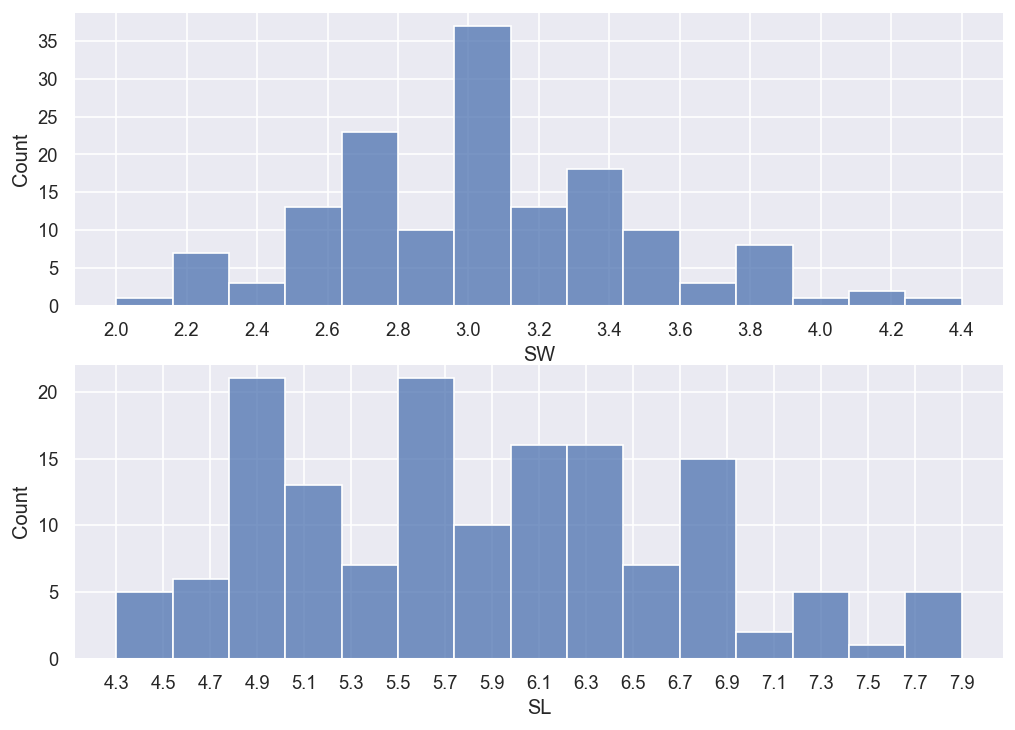

In [86]:
features = 'SW', 'SL'
axs = plt.subplots(2, 1, figsize=(10,7), dpi=120)[1]

for i, feat in enumerate(features):
    sns.histplot(iris, x=feat, bins=15, ax=axs[i])
    start, stop, step = iris[feat].min(), iris[feat].max(), 0.2
    axs[i].set_xticks(np.arange(start, stop + 1e-6, step))

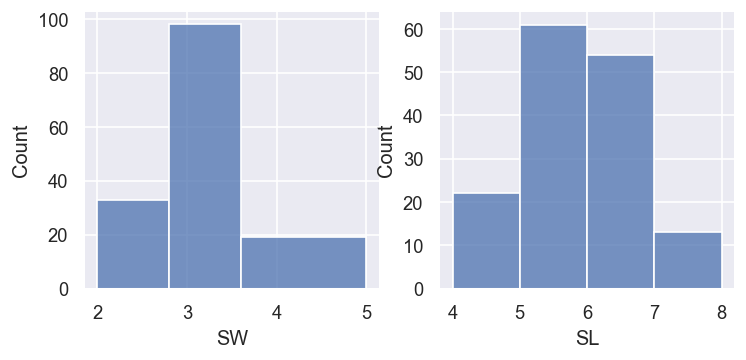

In [87]:
"""-1e-6: чтобы не делать include_lowest=True 
при построении таблицы сопряженности, потому что для других границ,
взятых с запасом, include_lowest не имеет смысла. """

bins = [(2 - 1e-6, 2.8, 3.6, 5), (4, 5, 6, 7, 8)]
axs = plt.subplots(1, 2, figsize=(7,3), dpi=120)[1]

for i, feat, feat_bins in zip(range(2), features, bins):
    sns.histplot(iris, x=feat, bins=feat_bins, ax=axs[i])

In [88]:
cuts = [pd.cut(iris[feat], bins=bins[i]) for i, feat in enumerate(features)]
pd.crosstab(*cuts, margins=True)

SL,"(4, 5]","(5, 6]","(6, 7]","(7, 8]",All
SW,,,,,
"(2.0, 2.8]",5,23,16,3,47
"(2.8, 3.6]",27,21,33,7,88
"(3.6, 5.0]",0,13,0,2,15
All,32,57,49,12,150


In [89]:
quetelet_index(pd.crosstab(*cuts))

array([[-0.50132979,  0.28779395,  0.04211898, -0.20212766],
       [ 0.43821023, -0.37200957,  0.14795918, -0.00568182],
       [-1.        ,  1.28070175, -1.        ,  0.66666667]])

Индекс Кетле показывает, на сколько процентов условная вероятность
строки отличается от ее безусловной вероятности; чем он больше, тем выше связь. При
условии, что длина выражается второй категорией, ширина попадает в категорию
самых широких листьев (третья строка) на $128.07\%$ чаще, чем в среднем, потому что ожидалось (исходя из гипотезы независимости категорий) $5.7$:

In [90]:
expected_freq(pd.crosstab(*cuts))

array([[10.02666667, 17.86      , 15.35333333,  3.76      ],
       [18.77333333, 33.44      , 28.74666667,  7.04      ],
       [ 3.2       ,  5.7       ,  4.9       ,  1.2       ]])

...а фактически имеем $13$, т.е. прирост составляет:

In [91]:
(13 - 5.7) / 5.7

1.280701754385965

[__scipy.stats.contingency.expected_freq__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.contingency.expected_freq.html#scipy-stats-contingency-expected-freq)

***
### <a id='toc1_3_2_'></a>[__Коэффициент хи-квадрат как индекс связи и визуализация его структуры__](#toc0_)

Относительно удачная визуализация таблицы сопряженности получается
с помощью индексов Кетле, взвешенных вероятностями соответствующих ячеек
таблицы. Сумма этих величин приводит к одному из наиболее популярных понятий анализа таблиц сопряженности, так называемому __коэффициенту сопряженности хи-квадрат__. Этот коэффициент был предложен К. Пирсоном (1901) как мера отклонения наблюдаемого двумерного
распределения в таблице сопряженности от условия статистической независимости 
признаков.

Два признака считаются статистически независимыми, если все возможные 
пары их категорий статистически независимы, т.е. вероятность/частота
их совместного появления равна произведению вероятностей этих категорий
по отдельности. К. Пирсон рассматривал ситуацию, когда два признака статистически 
независимы в популяции, но в рассматриваемой конкретной выборке
независимость не выполняется из-за случайных отклонений выборки. Он предложил взять квадрат разности наблюденной частоты и величины, полученной при
выполнении предположения независимости, и разделить его на вероятность, истинную для популяции. Суммарный индекс носит название __коэффициент Пирсона хи-квадрат__. Распределение суммарного коэффициента хи-квадрат, умноженного на численность выборки, при
условии справедливости гипотезы независимости в популяции, сходится к так
называемому __распределению хи-квадрат__, которое используется в статистике
для проверки гипотезы независимости двух признаков. Статистики утверждают
поэтому, что коэффициент может быть использован только для тестирования
гипотезы независимости, но не как мера коррелированности. Согласно этому
мнению коэффициент хи-квадрат должен использоваться для различения только
двух случаев: статистической независимости и ее отсутствия, так что его числовое 
значение само по себе не может использоваться как характеристика степени
зависимости. Впрочем, практики часто не следуют этому указанию и используют
хи-квадрат как меру связи между двумя категоризованными признаками. В этом нет ничего плохого или некорректного. __Коэффициент сопряженности хи-квадрат по своей сути не что иное как усредненный индекс Кетле, и значит, характеризует среднюю степень связи между категориями двух признаков. Более точно, усредненный индекс Кетле, а значит и коэффициент 
хи-квадрат, показывает, на сколько в среднем относительно увеличится
вероятность категории одного признака при условии, что категория другого признака 
становится известной.__

Умножим коэффициенты Кетле на частоты значений в соответствующих
ячейках. При этом следует выражать коэффициенты Кетле в абсолютных 
величинах, а не в процентах. В результате получаем таблицу, элементы которой
суммируются к $0.152$ — коэффициенту хи-квадрат Пирсона. Эта величина
характеризует средний прирост вероятности категорий одного признака, когда значение
второго признака становится известным: на $15.2\%$.

In [92]:
def chi2_table(crosstab, normalize=False):
    values = crosstab.values
    values_norm = values / values.sum()
    mrow, mcol = margins(values_norm)
    quetelet_index = (values_norm / mrow - mcol) / mcol
    arr = values_norm if normalize else values
    table = quetelet_index * arr        
    return table, table.sum()

In [93]:
chi2_table(frm_bnk, normalize=True)

(array([[ 0.04102564,  0.04642857, -0.04212963, -0.01481481],
        [-0.01367521, -0.01428571,  0.12037037,  0.02962963]]),
 0.15254884004884)

In [94]:
chi2_table(frm_bnk)

(array([[ 1.84615385,  2.08928571, -1.89583333, -0.66666667],
        [-0.61538462, -0.64285714,  5.41666667,  1.33333333]]),
 6.864697802197801)

[__scipy.stats.chi2_contingency__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.chi2_contingency.html#scipy-stats-chi2-contingency) | [__stats_tests.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/stats_tests.ipynb)

In [95]:
print_black(chi2_contingency(frm_bnk))

Chi2ContingencyResult(
    statistic=6.864697802197803,
    pvalue=0.07633765916624421,
    dof=3,
    expected_freq=array([[10.4, 11.2, 9.6, 4.8], [2.6, 2.8, 2.4, 1.2]]),
)



Рассмотрим два непересекающихся множества номинальных категорий
на множестве объектов $I$: $k = 1,2,\ldots,K$, $l = 1,2,\ldots,L$. Каждое множество категорий задает разбиение
множества $I$. Рассмотрим пересечение этих разбиений, чтобы агрегировать данные 
и проанализировать связь между двумя множествами категорий. Для пары
категорий $(k,l) \in K \cdot L$ посчитаем количество таких объектов в множестве $I$, которые 
попадают в обе категории одновременно. Обозначим через $N_{kl}$ количество
случаев совместного появления пары $(k,l)$. Очевидно, в сумме величины $N_{kl}$ дадут
$N$, общее число объектов в $I$, поскольку категории одного и того же множества
(а) не пересекаются и (б) покрывают все множество $I$. Таблица, в которой записаны 
все $N_{kl}$, или относительные величины — частоты $p_{kl} = N_{kl}/N$, называется
__таблицей сопряженности__ или __перекрестной классификацией__. Суммарные
значения — сумма по строке $N_k = \sum_{l} N_{kl}$ и сумма по столбцу $N_l = \sum_{k} N_{kl}$ (так же как
и их относительные значения с учетом числа строк и столбцов соответственно) — называются __маргинальными__ (поскольку находятся в крайнем столбце и крайней
строке, т.е. на «полях» таблицы сопряженности).

Вероятность (эмпирическая) того, что категория $l$ появится при наличии категории 
$k$, выражается как условная частота 

$$P(l \, | \, k) = \frac{p_{kl}}{p_k} = \frac{N_{kl}}{N_k},$$

т.е. частота
категории $l$ на подмножестве объектов, соответствующих категории $k$. Вероятность 
$P(l)$ категории $l$ на всем множестве $I$ есть $p_l = N_l/N$. Аналогичное обозначение 
используется для категорий $k$. Относительная разница между условной
и безусловной вероятностями называется (относительным) индексом Кетле:

$$q(l \, | \, k) = \frac{P(l \, | \, k) - P(l)}{P(l)},$$

то есть __индекс Кетле выражает
связь между категориями $k$ и $l$ как относительное изменение вероятности появления 
$l$ при условии__ $k$.

Используя простые алгебраические преобразования, можно получить более простое выражение:

$$q(l \, | \, k) = \frac{N_{kl}/N_k - N_l/N}{N_l/N} = \frac{N_{kl} \, N}{N_k \, N_l} - 1 = \frac{p_{kl}}{p_k p_l} - 1 = q(k,l).$$

Последнее обозначение, $q(k,l)$, подчеркивает тот факт, что коэффициент Кетле симметричен относительно индексов $k$ и $l$.

Выделение наибольших положительных и отрицательных значений индекса
Кетле визуализирует структуру связи между двумя множествами категорий. Это визуализированное представление может быть включено в традиционный
статистический контекст. Определим интегральный индекс связи Кетле $Q$ как
сумму парных индексов Кетле, взвешенных их частотами (вероятностями):

$$Q = \sum_{k=1}^K \sum_{l=1}^L p_{kl} \, q(l,k) = \sum_{k=1}^K \sum_{l=1}^L p_{kl} \left(\frac{p_{kl}}{p_k p_l} - 1\right) = \sum_{k=1}^K \sum_{l=1}^L \frac{p_{kl}^2}{p_k p_l} - 1.$$

Самое правое выражение не является чем-то необычным;
напротив, оно довольно часто встречается в статистическом анализе таблиц
сопряженности. Это не что иное, как альтернативная формула для коэффициента
сопряженности хи-квадрат Пирсона. __Коэффициент хи-квадрат был введен и с тех пор используется в совершенно другом контексте — в качестве меры
отклонения таблицы сопряженности от статистической независимости__.

Для объяснения сказанного сформулируем математическое определение понятия 
__статистической независимости__. Множества категорий $k$ и $l$ статистически
независимы, если $p_{kl} = p_k \cdot p_l$ для всех $k$ и $l$. Выполнение условия независимости
в реальности маловероятно. Пирсон предложил использовать относительные
квадратичные ошибки для того, чтобы оценить отклонение наблюдаемых частот
от статистической независимости. Он ввел следующий коэффициент,
который и называется __коэффициентом сопряженности хи-квадрат Пирсона__:

$$\Chi^2 = \sum_{k=1}^K \sum_{l=1}^L \frac{(p_{kl} - p_k p_l)^2}{p_k p_l} = \sum_{k=1}^K \sum_{l=1}^L \frac{p_{kl}^2}{p_k p_l} - 1.$$

Уравнение справа может быть доказано с использованием элементарной алгебры. Рассмотрим внутреннюю сумму из левой части последнего выражения:

$$\sum_{l=1}^L \frac{(p_{kl} - p_k p_l)^2}{p_k p_l} = \sum_{l=1}^L \frac{p_{kl}^2 - 2 \, p_{kl} \, p_k \, p_l + (p_k p_l)^2}{p_k p_l} =$$

$$= \sum_{l=1}^L \frac{p_{kl}^2}{p_k p_l} - 2 \underbrace{\sum_{l=1}^L p_{kl}}_{p_k} + \underbrace{\sum_{l=1}^L p_l}_{1} \cdot p_k = \sum_{l=1}^L \frac{p_{kl}^2}{p_k p_l} - p_k =$$

$$= \sum_{l=1}^L \frac{p_{kl}^2}{p_k p_l} - \sum_{l=1}^L p_{kl} = \sum_{l=1}^L p_{kl} \left(\frac{p_{kl}}{p_k p_l} - 1\right) = \sum_{l=1}^L p_{kl} \, q(l \, | \, k).$$

$$\Large \sum_{k=1}^K \sum_{l=1}^L \frac{(p_{kl} - p_k p_l)^2}{p_k p_l} = \sum_{k=1}^K \sum_{l=1}^L p_{kl} \, q(l \, | \, k) = Q = \Chi^2.$$

Популярность коэффициента $\Chi^2$ в статистике и смежных науках опирается
на теорему, доказанную Пирсоном. Если таблица сопряженности построена
по случайной и независимой выборке объектов из популяции, в которой выполняется условие статистической независимости (так что все отклонения обусловлены 
лишь случайностью выборки), то вероятностное распределение величины
$N \Chi^2$ сходится к распределению хи-квадрат с числом степеней свободы, равным
$(K - 1)(L - 1)$ при стремлении $N$ к бесконечности. Вероятностное распределение 
хи-квадрат с $m$ степенями свободы определяется как распределение суммы
квадратов $m$ случайных величин, каждая из которых распределена по стандартному 
нормальному закону. Это означает, что величина хи-квадрат может использоваться 
для проверки гипотезы о статистической независимости.

Теорема Пирсона не всегда применима в анализе данных, поскольку данные
могут быть не случайными, а наблюдения не обязательно независимыми. __Вместе 
с тем коэффициент хи-квадрат Пирсона на практике иногда используется
не столько для исследования независимости, сколько для оценки связи в таблицах 
сопряженности__. Эта побочная, и в свете теоремы Пирсона некорректная, цель
выглядит совершенно оправданной и корректной в свете уравнения $\Chi^2 = Q$. __Данное 
уравнение вообще придает коэффициенту $\Chi^2$ другую интерпретацию — в данном 
контексте это не мера отклонения от независимости, а мера взаимосвязи
между категориями — усредненный коэффициент Кетле. Таким образом, величина 
$\Chi^2 = Q$ — не что иное, как среднее относительное приращение вероятности
категории одного признака, полученное в результате того, что становится известной 
категория другого признака__.

***
## <a id='toc1_4_'></a>[__Решение заданий по темам главы__](#toc0_)

__Задание__. Найдите коэффициенты корреляции и детерминации для признаков _petal length_
и _petal width_ по данным об ирисах. Дайте интерпретацию величины 
коэффициента детерминации.

In [96]:
rho = pearsonr(iris.PL, iris.PW)[0]
rho  # коэффициент корреляции

0.9628654314027963

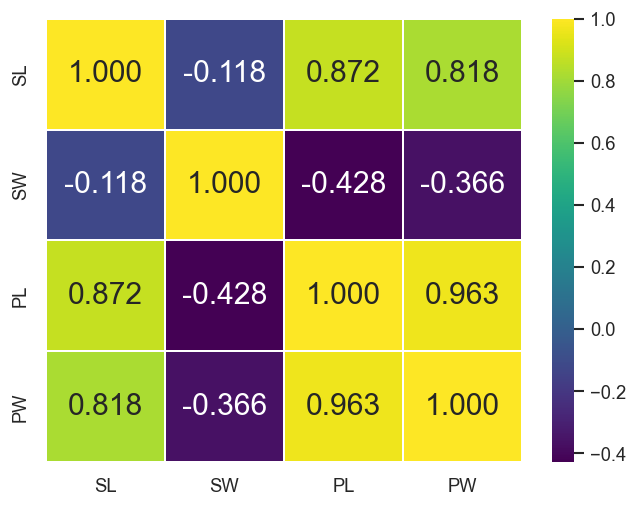

In [97]:
plt.figure(dpi=120)
sns.heatmap(iris.corr(), cmap='viridis', annot=True, fmt='.3f', 
            annot_kws={'size': 18}, linewidths=1)
plt.show()

In [98]:
r2 = rho**2
r2  # коэффициент детерминации

0.9271098389904932

Интерпретация коэффициента детерминации: Линейная связь признаков _petal length_ и _petal width_ снижает разбросы их значений на $\approx 92.7\%$. Линейная регрессия одного признака по другому объясняет $\approx 92.7\%$ дисперсии первого.

__Задание__. Постройте уравнение регрессии признака _petal width_ по признаку
_petal length_ по данным об ирисах, сравните спрогнозируемые значения 
признака _petal width_ с наблюденными значениями и рассчитайте значения
относительных ошибок. Вычислите среднее значение относительной ошибки.

Quick reminder:

$$\theta_1 = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^n (x_i - \overline{x})^2},\quad \theta_0 = \overline{y} - \theta_1 \overline{x}$$

$$\theta_1 = \rho \, \frac{\sigma_y}{\sigma_x}, \quad \rho = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{n \, \sigma_x \sigma_y}.$$

In [99]:
slope = rho * np.std(iris.PW) / np.std(iris.PL)
intercept = np.mean(iris.PW) - slope * np.mean(iris.PL)
slope, intercept

(0.41575541635241153, -0.3630755213190291)

Проверка:

In [100]:
np.polyfit(iris.PL, iris.PW, deg=1)

array([ 0.41575542, -0.36307552])

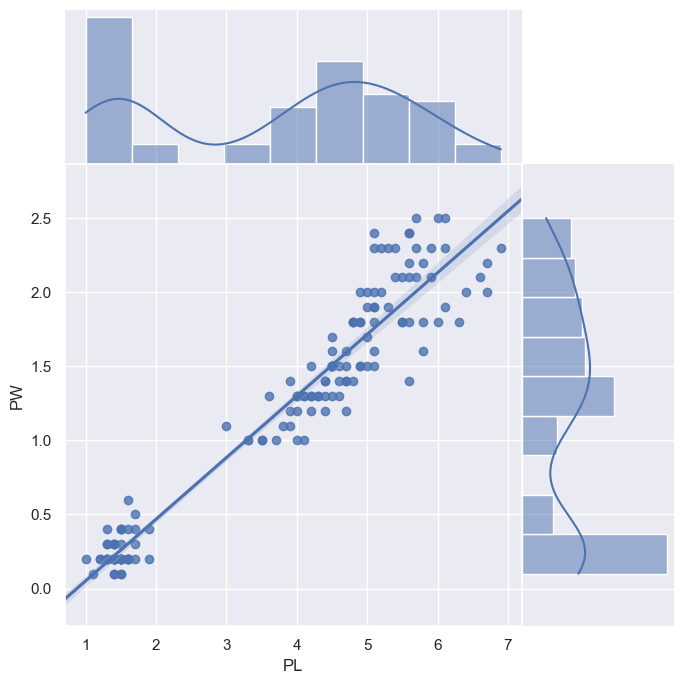

In [101]:
sns.jointplot(iris, x='PL', y='PW', kind='reg', 
              height=7, ratio=3, space=0, truncate=False)

In [102]:
iris_PW_pred = slope * iris.PL + intercept
error = np.abs((iris.PW - iris_PW_pred) / iris.PW)
error

0      0.094910
1      0.094910
2      0.112967
3      0.302788
4      0.094910
         ...   
145    0.217890
146    0.096999
147    0.100574
148    0.181738
149    0.023735
Length: 150, dtype: float64

In [103]:
np.mean(error)

0.20565099039146456

In [104]:
mean_absolute_percentage_error(iris.PW, iris_PW_pred)

0.20565099039146456

In [105]:
model = sm.OLS(iris.PW, sm.add_constant(iris.PL))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PW   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1882.
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           4.68e-86
Time:                        16:21:48   Log-Likelihood:                 24.796
No. Observations:                 150   AIC:                            -45.59
Df Residuals:                     148   BIC:                            -39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3631      0.040     -9.131      0.000      -0.442      -0.285
PL             0.4158      0.010     43.387      0.000       0.397       0.435
==============================================================================
Omnibus:                        5.765   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.555
Skew:                           0.359   Prob(JB):                       0.0622
Kurtosis:                       3.611   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
res.params

const   -0.363076
PL       0.415755
dtype: float64

In [107]:
res.rsquared

0.9271098389904927

In [108]:
mean_absolute_percentage_error(iris.PW, res.fittedvalues)

0.2056509903914647

__Задание__ по теме Линейная регрессия и бутстреп.

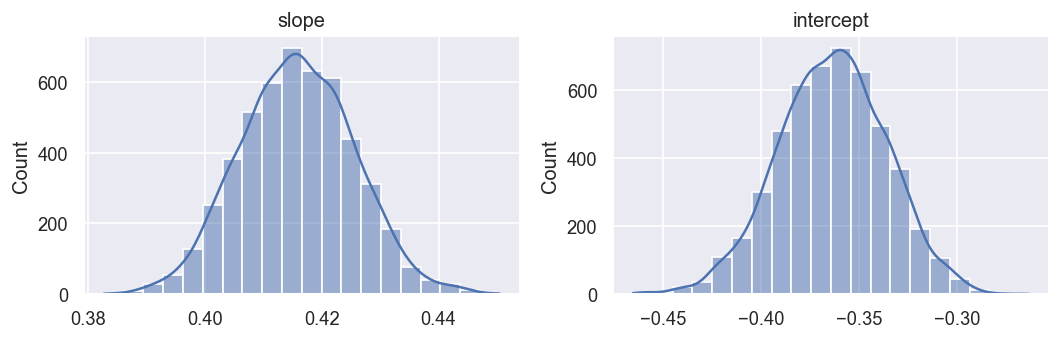

{
    "n_resamples": 5000,
    "conf_level": 0.95,
    "slope": {
        "mean": 0.4158196462155827,
        "ci_non_pivotal": (0.3971019785888259, 0.43481659103671194),
        "ci_pivotal": (0.3967722640680929, 0.4348670283630725),
    },
    "intercept": {
        "mean": -0.363529344857713,
        "ci_non_pivotal": (-0.41920744001560656, -0.31028802082199713),
        "ci_pivotal": (-0.4175330550359778, -0.30952563467944816),
    },
}



In [109]:
print_black(plot_slope_and_intercept_bs_distrs(
    iris.PL, iris.PW,
    n_resamples=5000
))

__Задание__. Как объяснить отрицательную корреляцию между _sepal length_ и _sepal width_? Это странно, ведь интуитивно корреляция между длиной и шириной чашелистика должна быть положительной — оба характеризуют размер!

In [110]:
pearsonr(iris.SL, iris.SW)[0]

-0.11756978413300208

Чтобы понять, в чем причина такой низкой и даже отрицательной корреляции,
необходимо учесть, что выборка не однородна: датасет _iris_ состоит
из $50$ образцов каждого из трех таксонов. Когда таксоны разделены, положительная корреляция обнаруживается. __Это пример эффекта неоднородности выборки на результаты анализа данных__.

In [111]:
iris[['SL', 'SW']].groupby(iris_y).corr()

SL        SW
target                       
0      SL  1.000000  0.742547
       SW  0.742547  1.000000
1      SL  1.000000  0.525911
       SW  0.525911  1.000000
2      SL  1.000000  0.457228
       SW  0.457228  1.000000

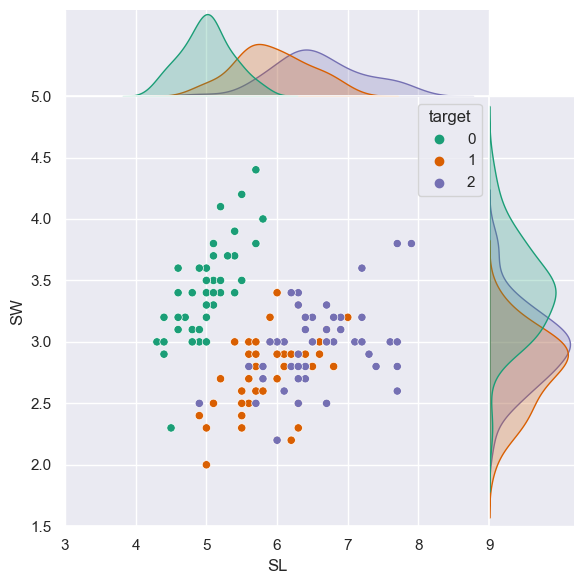

In [112]:
sns.jointplot(iris, x='SL', y='SW', hue=iris_y, palette='Dark2', 
              space=0, xlim=(3, 9), ylim=(1.5, 5))

__Задание__. Постройте табличную регрессию длины чашелистика _sepal length_ по таксону
и найдите корреляционное отношение.

In [113]:
regression_table(iris, qual_feature=iris_y, quant_feature='SL')

,count,mean,std
,SL,SL,SL
target,,,
0,50,5.006000,0.352490
1,50,5.936000,0.516171
2,50,6.588000,0.635880
All,150,5.843333,0.828066


In [114]:
cor_relation(iris, qual_feature=iris_y, quant_feature='SL')

0.6135180536056775

Табличная регрессия длины чашелистика _sepal length_ по таксонам объясняет порядка $61\%$ дисперсии длины чашелистика. Стандартное отклонение внутри категорий сравнительно невелико,
порядка $10\%$ от среднего.

__Задание__. Постройте табличную регрессию длины лепестка _petal length_ по таксону и найдите корреляционное отношение.

In [115]:
regression_table(iris, qual_feature=iris_y, quant_feature='PL')

,count,mean,std
,PL,PL,PL
target,,,
0,50,1.462,0.173664
1,50,4.260,0.469911
2,50,5.552,0.551895
All,150,3.758,1.765298


Очень высокий уровень корреляционного отношения определяется, по-видимому, тем, что внутригрупповые стандартные отклонения количественного признака значительно меньше, чем его стандартное отклонение на всем множестве.

In [116]:
cor_relation(iris, qual_feature=iris_y, quant_feature='PL')

0.9405740553710736

__Задание__. Дана таблица данных о восьми студентах с двумя признаками:

In [117]:
students = pd.DataFrame({'score': [50, 80, 80, 60, 60, 40, 50, 40],
                         'prof': ['IT']*3 + ['BA']*5})
students

,score,prof
0,50,IT
1,80,IT
2,80,IT
3,60,BA
4,60,BA
5,40,BA
6,50,BA
7,40,BA


* Постройте регрессионную таблицу для прогнозирования оценки по профессии.

In [118]:
regression_table(students, qual_feature='prof', quant_feature='score')

,count,mean,std
,score,score,score
prof,,,
BA,5,50.0,10.000000
IT,3,70.0,17.320508
All,8,57.5,15.811388


В этом задании в учебнике, похоже, допущены ошибки. Во-первых, стандартные отклонения посчитаны при __`ddof=0`__, хотя во всех примерах построения регрессионной таблицы до этого бралось __`ddof=1`__. 

In [119]:
students.groupby('prof').score.std(ddof=0)

prof
BA     8.944272
IT    14.142136
Name: score, dtype: float64

In [120]:
students.score.std(ddof=0)

14.79019945774904

* Спрогнозируйте оценку нового студента профессии _BA_.

Для студента профессии _BA_ наиболее вероятная оценка будет в интервале $(50 \pm 10)$.

* Найдите корреляционное отношение для этой таблицы.

In [121]:
cor_relation(students, qual_feature='prof', quant_feature='score')

0.30000000000000004

В учебнике почему-то взвешиваются не дисперсии, а стандартные отклонения:
$$\eta^2 = 1 - \frac{(5 \cdot 8.9 + 3 \cdot 14.1)/8}{14.79} = 0.266,$$
что приводит к неправильному результату.

__Задание__. Найдите распределение, энтропию и индекс Джини для признака _hsp_ в данных
о малых городах английского побережья.

In [122]:
values, counts = np.unique(towns.hsp, return_counts=True)

In [123]:
entropy(counts, base=2)  # no pre-normalization required

1.1321993681628737

In [124]:
p = counts / np.sum(counts)
h = -np.sum(p * np.log2(p))
h  # entropy

1.1321993681628735

In [125]:
h / np.log2(values.size)  # relative

0.7143382683487616

In [126]:
g = 1 - np.sum(p**2)
g  # Gini index

0.4859259259259259

In [127]:
g / ((values.size - 1) / values.size)  # relative

0.7288888888888888

__Задание__. Постройте табличную регрессию признака численность населения _ppl_
по признаку число бассейнов _swp_ по данным о городах английского побережья, а также величину корреляционного отношения. Дайте интерпретацию этой величины.

In [128]:
regression_table(towns, qual_feature='swp', quant_feature='ppl')

,count,mean,std
,ppl,ppl,ppl
swp,,,
0,26,4116.653846,2609.874969
1,16,11170.312500,7286.386134
2,3,15017.666667,4433.155122
All,45,7351.355556,6193.245629


In [129]:
cor_relation(towns, qual_feature='swp', quant_feature='ppl')

0.37109028677369027

Интерпретация: Табличная регрессия признака численность населения по признаку число бассейнов объясняет $37.1\%$ дисперсии признака численность населения.

__Задание__. Постройте таблицу вкладов категорий для признаков _sepal length_ и таксон.

In [130]:
contribution_table(iris, qual_feature=iris_y, quant_feature='SL')

,proportion,mean,contribution
,SL,SL,SL
target,,,
0,0.333333,5.006000,0.233709
1,0.333333,5.936000,0.002862
2,0.333333,6.588000,0.184843
All,1.000000,5.843333,0.000000


__Задание__. Разделите ирисы на четыре группы по признаку _sepal length_ и постройте таблицу сопряженности полученного номинального признака с разбиением по таксонам как в абсолютных численностях, так и в относительных частотах.

In [131]:
# для относительных частот normalize=True
pd.crosstab(iris_y, pd.cut(iris.SL, bins=4), margins=True)

SL,"(4.296, 5.2]","(5.2, 6.1]","(6.1, 7.0]","(7.0, 7.9]",All
target,,,,,
0,39,11,0,0,50
1,5,29,16,0,50
2,1,10,27,12,50
All,45,50,43,12,150


__Задание__. Рассчитайте индексы Кетле для пары тип протокола _Pr_ / тип атаки _A_.

In [132]:
pr_a = pd.crosstab(cyber_attacks.Pr, cyber_attacks.A)
pr_a

A,ap,no,sa,sm
Pr,,,,
ICMP,0,0,0,10
TCP,23,30,11,0
UDP,0,26,0,0


In [133]:
quetelet_index(pr_a)

array([[-1.        , -1.        , -1.        ,  9.        ],
       [ 0.5625    , -0.16294643,  0.5625    , -1.        ],
       [-1.        ,  0.78571429, -1.        , -1.        ]])

__Задание__. Постройте разложение коэффициента хи-квадрат для пары таксон / _petal length_.

Подсказка. Прежде всего категоризуйте количественный признак _petal length_. Для этого можно использовать бины одинакового размера или любой другой разумный способ.

<AxesSubplot: xlabel='PL', ylabel='Count'>

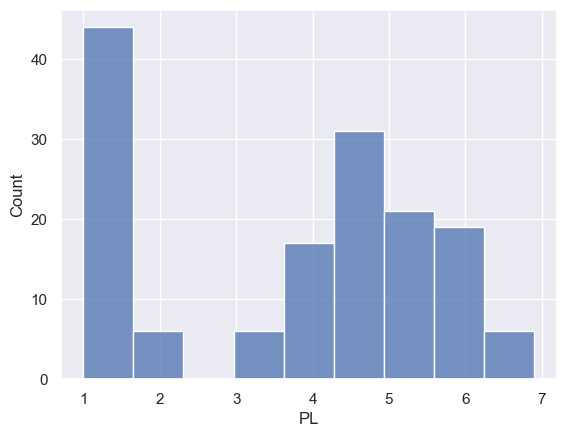

In [134]:
sns.histplot(iris, x='PL')

<AxesSubplot: xlabel='target', ylabel='PL'>

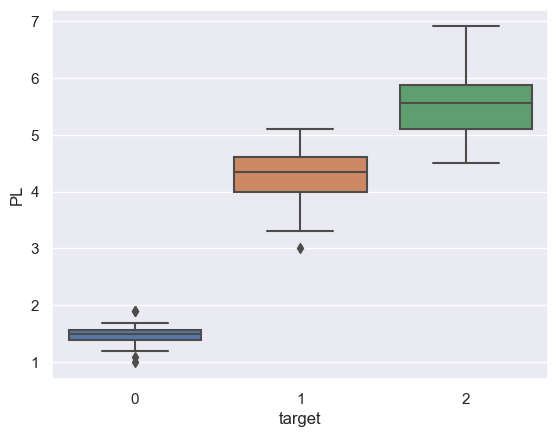

In [135]:
sns.boxplot(iris, x=iris_y, y='PL')

In [136]:
y_pl = pd.crosstab(iris_y, pd.cut(iris.PL, bins=range(1, 8, 2), include_lowest=True))
y_pl

PL,"(0.999, 3.0]","(3.0, 5.0]","(5.0, 7.0]"
target,,,
0,50,0,0
1,1,48,1
2,0,9,41


In [137]:
quetelet_index(y_pl) * y_pl

PL,"(0.999, 3.0]","(3.0, 5.0]","(5.0, 7.0]"
target,,,
0,97.058824,-0.000000,-0.000000
1,-0.941176,73.263158,-0.928571
2,-0.000000,-4.736842,79.071429


In [138]:
chi2_table(y_pl)

(array([[97.05882353, -0.        , -0.        ],
        [-0.94117647, 73.26315789, -0.92857143],
        [-0.        , -4.73684211, 79.07142857]]),
 242.78681999115437)

In [139]:
pearson_chi2 = chi2_contingency(y_pl).statistic
pearson_chi2

242.78681999115435

In [140]:
res = chi2_table(y_pl, normalize=True)
res

(array([[ 0.64705882, -0.        , -0.        ],
        [-0.00627451,  0.48842105, -0.00619048],
        [-0.        , -0.03157895,  0.52714286]]),
 1.6185787999410293)

In [141]:
np.isclose(res[1] * iris.shape[0], pearson_chi2)

True

__Задание__. Из $100$ покупателей новогодних подарков 
$50$ потратили по $60$ долл., $20$ потратили по $100$ долл., и $30$ — по $150$ долл. каждый.

К этой задаче из второй главы добавляются следующие условия. Каждый, кто тратит на покупки
$60$ долл., это обязательно мужчина. Каждый, кто тратит $100$, — всегда женщина. А среди
оставшихся $30$ человек половина женщин и половина мужчин. Постройте таблицу
сопряженности двух признаков: пол и расходы на покупки. Найдите и объясните
величину коэффициента Кетле для пары категорий «женщины, которые тратят
по $100$ долл.» (пары в смысле пересечения категорий признаков).

In [142]:
labels, values= [], []
params = zip([50, 20, 15, 15], [60, 100, 150, 150], ['m', 'f'] * 2)

for n, value, label in params:
    labels.extend([label] * n)
    values.extend([value] * n)
    
gifts = pd.crosstab(pd.Series(labels, name='gender'), 
                    pd.Series(values, name='expenses'))
gifts

expenses,60,100,150
gender,,,
f,0,20,15
m,50,0,15


In [143]:
quetelet_index(gifts)

array([[-1.        ,  1.85714286,  0.42857143],
       [ 0.53846154, -1.        , -0.23076923]])

In [144]:
expected_freq(gifts)

array([[17.5,  7. , 10.5],
       [32.5, 13. , 19.5]])

In [145]:
(20 - 7) / 7

1.8571428571428572

Это означает, что вероятность того, что индивид в данной категории расходов
окажется женщиной, больше средней частоты женщин на $186\%$. Иначе: То обстоятельство (достоверный факт), что покупатель — женщина, повышает частоту категории «расход 100 долл.» на $186\%$. 

__Задание__. Рассмотрим два бинарных признака и построим для них таблицу
сопряженности (ее часто называют _четырехклеточной таблицей_), где
символы $a, b, c, d$ используются для обозначения [абсолютных] частот совместного появления.

$$\begin{array}{|c|c|c|c|} \hline
X/Y & \text{Да} & \text{Нет} & \text{Итого} \\ \hline
\text{Да} & a & b & a + b \\ \hline
\text{Нет} & c & d & c + d \\ \hline
\text{Итого} & a + c & b + d & N = a + b + c + d \\ \hline
\end{array}$$

* Докажите, что коэффициент Кетле $q(\text{Да} \, | \, \text{Да})$ равен

$$q(\text{Да} \, | \, \text{Да}) = \frac{ad - bc}{(a + b) (a + c)}.$$

$$q(\text{Да} \, | \, \text{Да}) =$$

$$= \frac{(a/N) \, / \, (a + b)/N - (a + c) / N}{(a + c) / N} = \frac{N(aN - (a + b)(a + c))}{N(a + b)(a + c)} =$$

$$= \frac{a(a + b + c + d) - a^2 - ac - ab - bc}{(a + b)(a + c)} = \frac{ad - bc}{(a + b) (a + c)}.$$

In [146]:
a, b, c, d = sym.symbols('a b c d')
N = a + b + c + d

In [147]:
((a / (a + b) - (P := (a + c) / N)) / P).factor()

(a*d - b*c)/((a + b)*(a + c))

* Докажите, что усредненный коэффициент Кетле $Q$, или коэффициент Пирсона $\Chi^2$, равен 

$$Q = \Chi^2 = \frac{(ad - bc)^2}{(a + b)(a + c)(b + d)(c + d)}.$$

In [148]:
marg = product([a + b, c + d], [a + c, b + d])

# count observed and count expected
NChi2 = sum((obs - (exp := np.multiply(*next(marg)) / N))**2 / exp
            for obs in (a, b, c, d)).factor()
NChi2

(a*d - b*c)**2*(a + b + c + d)/((a + b)*(a + c)*(b + d)*(c + d))

__Задание__. Докажите, что коэффициент корреляции двух бинарных $1/0$ признаков, 
рассматриваемых как количественные, может быть выражен в терминах
четырехклеточной таблицы как $\rho = \sqrt{Q}$, т.е.

$$\rho = \frac{ad - bc}{\sqrt{(a + b)(a + c)(b + d)(c + d)}}.$$

[__Relationship between the phi, Matthews and Pearson correlation coefficients__](https://stats.stackexchange.com/questions/59343/relationship-between-the-phi-matthews-and-pearson-correlation-coefficients)

$$\begin{array}{|c|c|c|c|} \hline
& y = 1 & y = 0 & \text{total} \\ \hline
x = 1 & n_{11} & n_{10} & n_{1 \bullet} \\ \hline
x = 0 & n_{01} & n_{00} & n_{0 \bullet} \\ \hline
\text{total} & n_{\bullet 1} & n_{\bullet 0} & n \\ \hline
\end{array}$$

The Pearson's correlation between two Bernoulli random variables $x$ and $y$ is:

$$\rho = \frac{\mathbb{E} [(x - \mathbb{E}[x])(y - \mathbb{E}[y])]} {\sqrt{\text{Var}[x] \, \text{Var}[y]}}
= \frac{\mathbb{E} [xy] - \mathbb{E}[x] \, \mathbb{E}[y]}{\sqrt{\text{Var}[x] \, \text{Var}[y]}}.$$

$$\mathbb{E}[x] = \frac{n_{1\bullet}}{n} \quad
\text{Var}[x] = \frac{n_{0\bullet}n_{1\bullet}}{n^2} \quad
\mathbb{E}[y] = \frac{n_{\bullet 1}}{n} \quad
\text{Var}[y] = \frac{n_{\bullet 0}n_{\bullet 1}}{n^2} \quad
\mathbb{E}[xy] = \frac{n_{11}}{n}.$$

$$\rho = \frac{\frac{n_{11}}{n} - \frac{n_{1 \bullet} n_{\bullet 1}}{n^2}}{\frac{1}{n^2} \sqrt{n_{0 \bullet} n_{1 \bullet} n_{\bullet 0} n_{\bullet 1}}} = \frac{n_{1 1} n - n_{1\bullet} n_{\bullet 1}}{\sqrt{n_{0\bullet}n_{1\bullet}  n_{\bullet 0}n_{\bullet 1}}} =$$

$$= \frac{a(a + b + c + d) - (a + b)(a + c)}{\sqrt{(a + b)(a + c)(b + d)(c + d)}} = \frac{ad - bc}{\sqrt{(a + b)(a + c)(b + d)(c + d)}}.$$